# Preliminary modelling for Borrellia

First, we load all packages and data. 

In [1]:
######## GAM model with manual hurdle component ##########
library(tidyverse)
library(mgcv) # for GAMs
library(randomForest) # for random forest
library("brms")

tck <- read.csv("data_derived/MASTER_all_tck_data_merged.csv")


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.2.1          ✔ purrr   0.3.3     
✔ tibble  2.1.3          ✔ dplyr   0.8.3     
✔ tidyr   1.0.0.9000     ✔ stringr 1.4.0     
✔ readr   1.3.1          ✔ forcats 0.4.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: nlme

Attaching package: ‘nlme’

The following object is masked from ‘package:dplyr’:

    collapse

This is mgcv 1.8-31. For overview type 'help("mgcv-package")'.
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin

Loading required package: Rcpp
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Loading 'brms' package (version 2

## Filtering dataset and adjusting values

First, let's see how many plots were tested and how many times (number of tests)

In [2]:
#### Filter tick dataset and adjust ####

## How many plots were tested, and how many times?
tck %>%
  mutate(tested=ifelse(is.na(testingID),"no","yes")) %>%
  select(plotID, tested) %>% table(useNA="ifany")


          tested
plotID        no   yes
  ABBY_001    70     0
  ABBY_002    63     0
  ABBY_003    63     0
  ABBY_005    67     0
  ABBY_006    63     0
  ABBY_023    68     0
  BARR_021     3     0
  BARR_030     9     0
  BARR_031     9     0
  BARR_034     9     0
  BARR_037     9     0
  BARR_084     9     0
  BART_002    93     0
  BART_010    87     0
  BART_011    87     0
  BART_015    90     0
  BART_019    87     0
  BART_029    66     0
  BLAN_002   180     0
  BLAN_004   123     0
  BLAN_005  2193  2807
  BLAN_008   126     0
  BLAN_012   221     6
  BLAN_015   798     2
  BLAN_020     3     0
  BONA_002    15     0
  BONA_004    12     0
  BONA_012    15     0
  BONA_013    12     0
  BONA_020    12     0
  BONA_044    15     0
  CLBJ_032    87     0
  CLBJ_033    91     0
  CLBJ_034    87     0
  CLBJ_036    81     0
  CLBJ_040    87     0
  CLBJ_043    87     0
  CPER_001    66     0
  CPER_002    66     0
  CPER_003    66     0
  CPER_004    66     0
  CPER_005    66 

In [3]:
## What type of ticks did they test?
tck %>%
  mutate(tested=ifelse(is.na(testingID),"no","yes")) %>%
  select(lifeStage, tested) %>% table(useNA="ifany") 

         tested
lifeStage     no    yes
    Adult   9815      0
    Larva 260512      0
    Nymph  13821 155154

There are many plots that are never tested, and only nymphs were ever tested. Additionally, we are really only interested in Borrelia, since this causes Lyme disease. Let's look at the distribution of negative-Borrelia and non-tested sites. First, aggregate the dataset so that each line is ONE SAMPLE that tells us number tested, proportion tested, etc

In [4]:
## Aggregate by plotID:dayOfYear:year. Count number of different life stages; create proportiontested/positive etc
tck_allsamples_borr <- tck %>%
  mutate(tested=ifelse(is.na(Borrelia_sp.),0,1) # Was each tick  ever tested for borrellia?
         ,isPositive=ifelse(Borrelia_sp.=="Positive", 1,0) # And if it was tested, was it positive or negative?
  ) %>%
  group_by(domainID, siteID, nlcdClass, plotID, elevation, collectDate, dayOfYear, year, month, totalSampledArea) %>% # collapse by sample-- summing all tck counts together
  summarize(numberTested=sum(tested, na.rm=TRUE) # number of tested ticks in that sample
            ,n=n() # total ticks in that sample
            , numberPositive=sum(isPositive,na.rm = TRUE) # number of positive ticks in that sample
            , nAdult=sum(lifeStage=="Adult")
            , nNymph=sum(lifeStage=="Nymph")
            , nLarva=sum(lifeStage=="Larva")) %>%
  ungroup() %>%
  mutate(proportionTested=numberTested/nNymph # proportion of all nymph ticks tested-- only nymphs were ever tested.
         , proportionPositive=numberPositive/numberTested
         , tested = ifelse(numberTested > 0 , TRUE, FALSE) # new true/false tested, which is summed across ticks
         , testingStatus = ifelse(numberTested > 0, "Tested", ifelse(nNymph>0, "Nymphs present, not tested", "No nymphs"))
         ) %>%
  mutate(nlcdClass=factor(nlcdClass, levels=c("emergentHerbaceousWetlands","cultivatedCrops","pastureHay","grasslandHerbaceous"
                                              ,"dwarfScrub","shrubScrub","sedgeHerbaceous"
                                              ,"woodyWetlands","deciduousForest","evergreenForest","mixedForest"))) %>%
  mutate(borrPresent = ifelse(numberPositive>0,1,0)
         , domainID = factor(as.character(domainID))
         , siteID = factor(as.character(siteID))
         , plotID = factor(as.character(plotID))
         , year = factor(year)
         , tckDensity = sum(c(nLarva, nNymph, nAdult))/totalSampledArea
         , ntckDensity = nNymph/totalSampledArea
         , NLtckDensity = sum(c(nNymph, nAdult), na.rm = TRUE)/totalSampledArea
         , atckDensity = nAdult/totalSampledArea)  %>%
  mutate(lognymphDensity=log(ntckDensity)
         , logNLtckDensity=log(NLtckDensity)
         , logtckDensity = log(tckDensity)
         , logadultDensity=log(atckDensity))

 Now, let's look at our data and see the degree of zero-inflation there is:

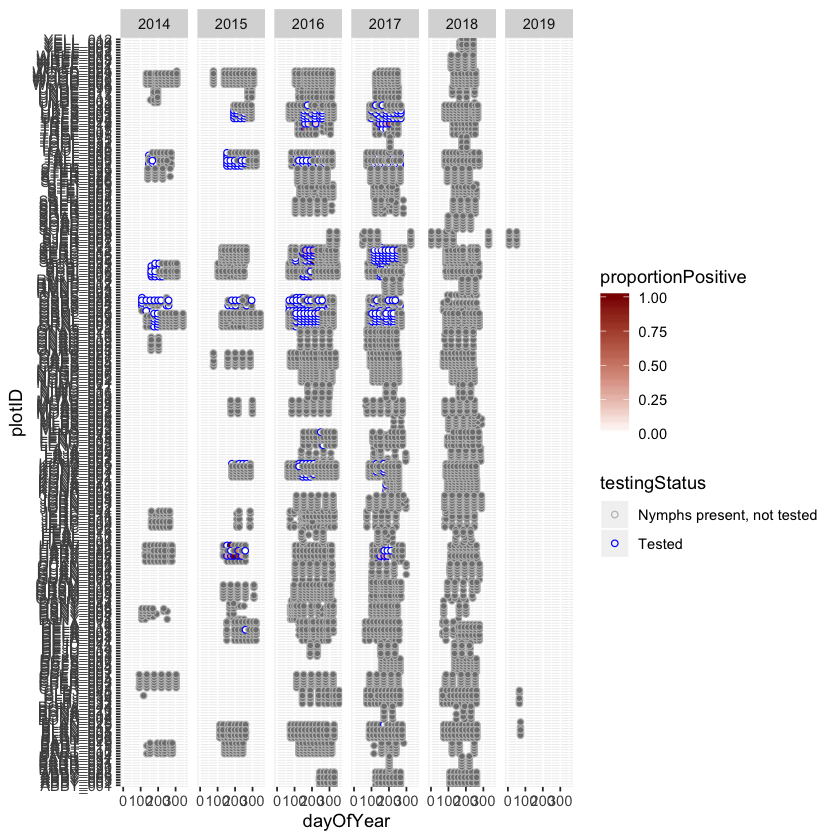

In [5]:
## Plot over time, by year, by plot, to see how zero-inflated it is.
tck_allsamples_borr %>%
  ggplot() + geom_point(aes(x=dayOfYear, y=plotID, fill=proportionPositive, col=testingStatus), pch=21) +
  scale_fill_gradient(low="white", high="darkred") +
  scale_color_manual(values=c(Tested="blue", `Nymphs present, not tested`="grey", `No nymphs`="white")) +
  facet_grid(.~year)

What we see is that there are many plots where there were never tested, even though nymphs were present. Therefore, we should remove those sites from analyses.

In [6]:
## Let's filter out plots that NEVER had any positive borrelia
infectedPlots <- tck %>%
  filter(Borrelia_sp.=="Positive") %>%
  select(plotID) %>%pull() %>% unique()

## Filtering same data as above; only now removing non-infected plots.
tck_borrelia_positivePlots <- tck_allsamples_borr %>%
  filter(plotID %in% as.character(infectedPlots))


Now, we can look at the distribution of zeros across all plots that were tested at least once.

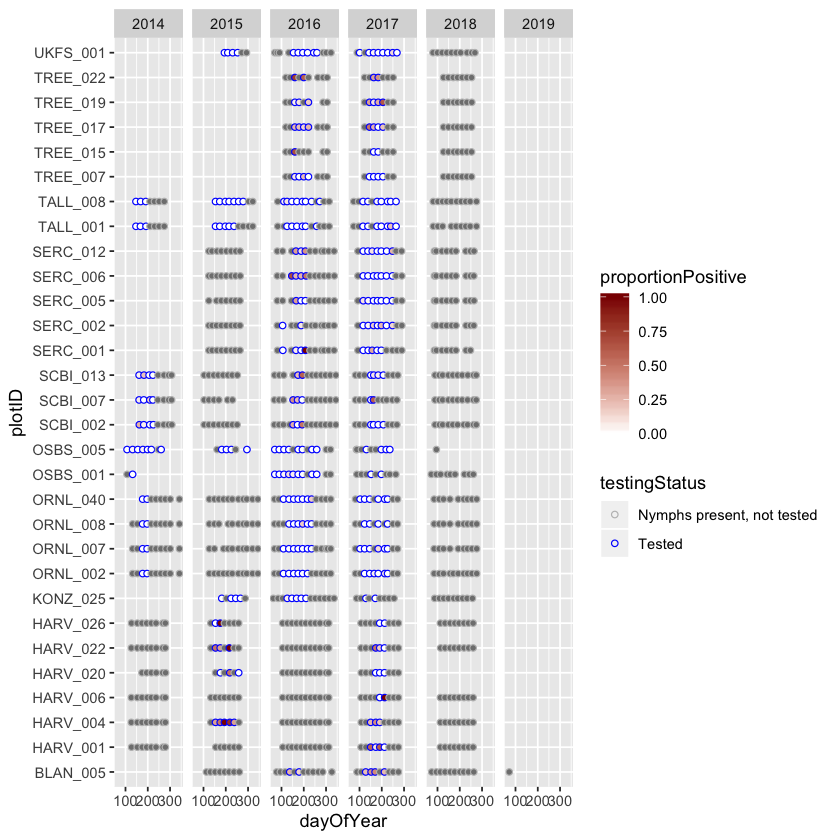

In [7]:
tck_borrelia_positivePlots %>%
  ggplot() + geom_point(aes(x=dayOfYear, y=plotID, fill=proportionPositive, col=testingStatus), pch=21) +
  scale_fill_gradient(low="white", high="darkred") +
  scale_color_manual(values=c(Tested="blue", `Nymphs present, not tested`="grey", `No nymphs`="white")) +
  facet_grid(.~year)

There are a lot of plot:collectionDate combinations that were simply never nested. So, let's remove those as well and re-plot the samples.

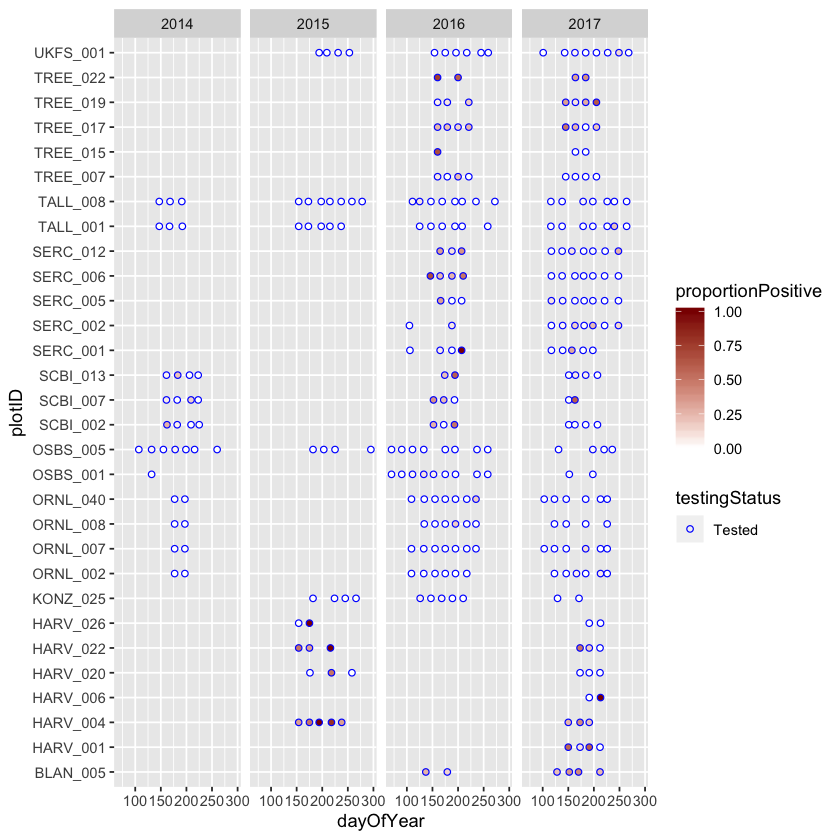

In [8]:
## There are STILL a lot of zeros-- zeros where there are nymphs but they were never tested.
# Let's remove those.
tck_borrelia <- tck_borrelia_positivePlots %>%
  mutate(numberPositive=ifelse(numberTested==0,NA,numberPositive)) %>% # Make sure that numberPositive is not artificially zero-- if there were no tests, it should be NA
  filter(numberTested!=0) # get rid of all samples where the didn't actually test.

tck_borrelia %>%
  ggplot() + geom_point(aes(x=dayOfYear, y=plotID, fill=proportionPositive, col=testingStatus), pch=21) +
  scale_fill_gradient(low="white", high="darkred") +
  scale_color_manual(values=c(Tested="blue", `Nymphs present, not tested`="grey", `No nymphs`="white")) +
  facet_grid(.~year)


What we have are 311 samples left (see code below), where there is still an inflation of zeros, but is much, much better than before.


In [9]:
nrow(tck_borrelia)
# There are only 311 samples left-- still zero inflated, but slightly better.


[1] 311

## Preliminary Plotting of prevalence and count

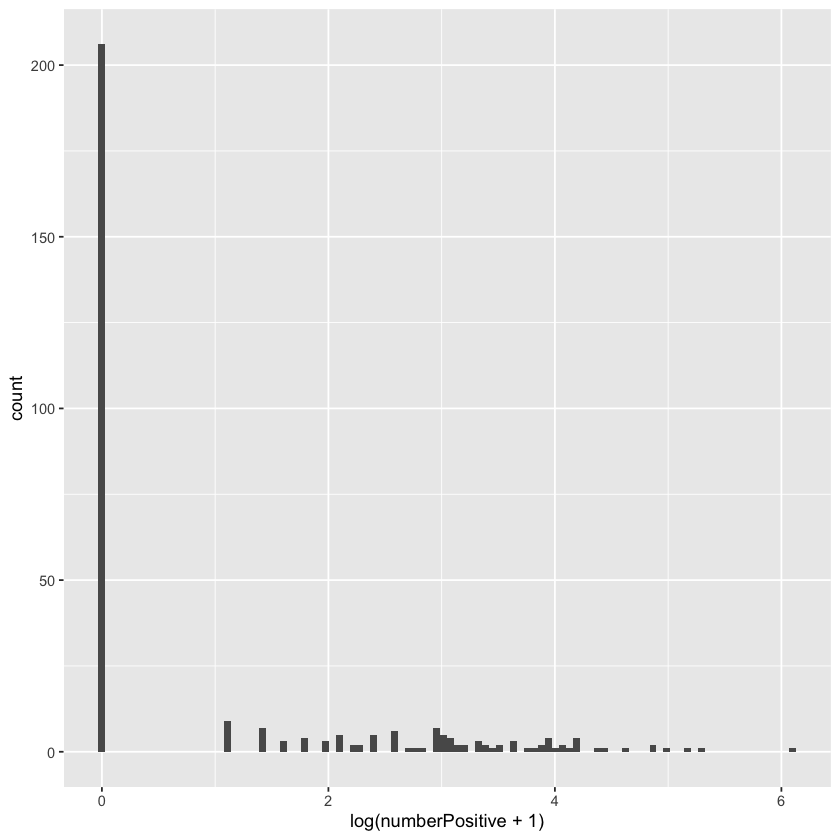

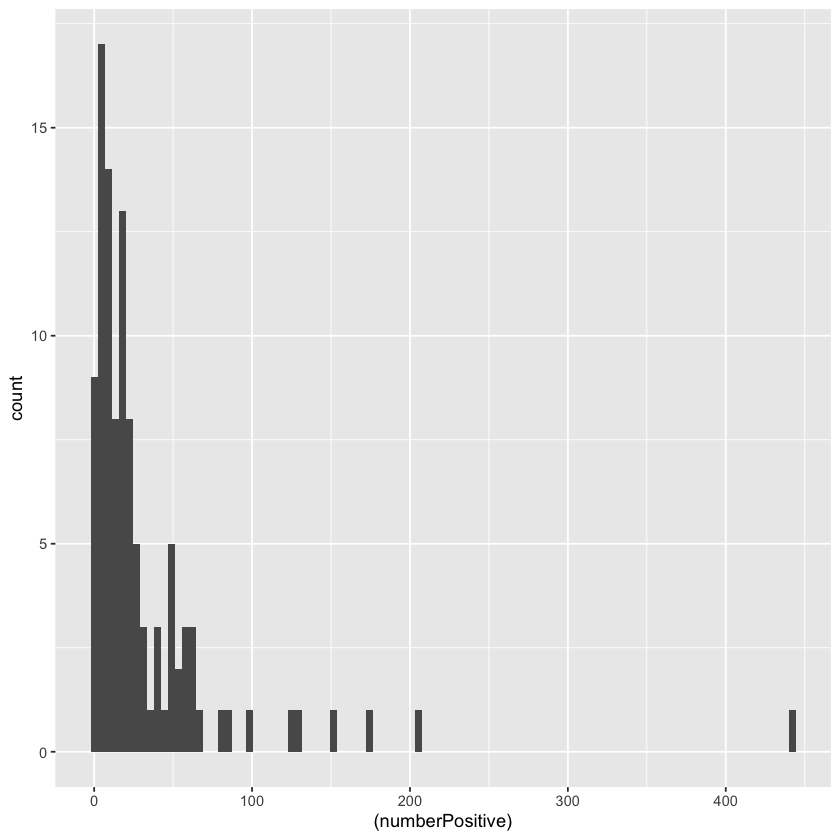

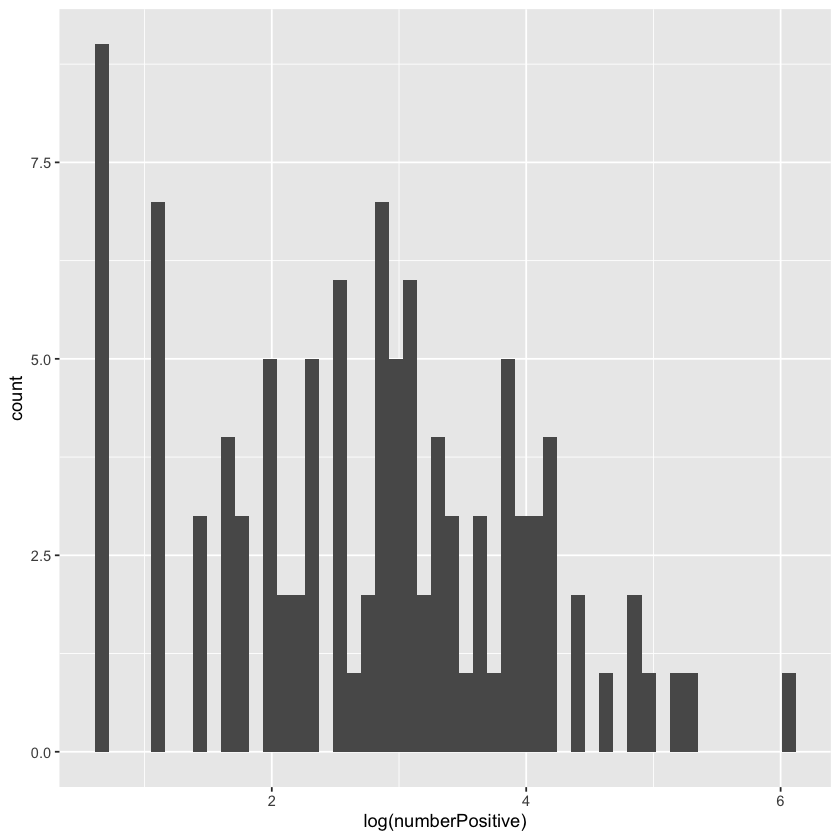

In [10]:
#### Preliminary Plotting ####

# First, what is the distribution of Borrelia prevalence?
tck_borrelia %>%
  ggplot() +geom_histogram(aes(x=log(numberPositive+1)), bins=100)
# histogram without any zeros
tck_borrelia %>%
  filter(numberPositive>0) %>%
  ggplot() +geom_histogram(aes(x=(numberPositive)), bins=100)
# histogram log abundance, no zeros
tck_borrelia %>%
  filter(numberPositive>0) %>%
  ggplot() +geom_histogram(aes(x=log(numberPositive)), bins=50)


Are the number of positive ticks proportional to infection prevalence?

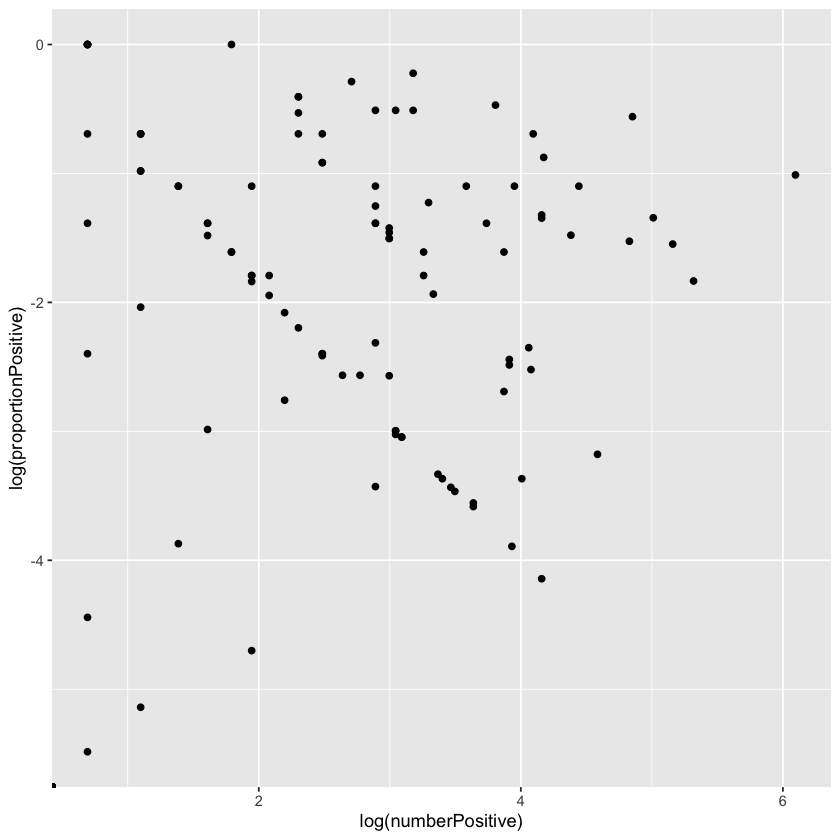

In [11]:
# What is relationship between proportion positive and number positive
tck_borrelia_train %>%
  ggplot() +geom_point(aes(x=log(numberPositive), y=log(proportionPositive)))

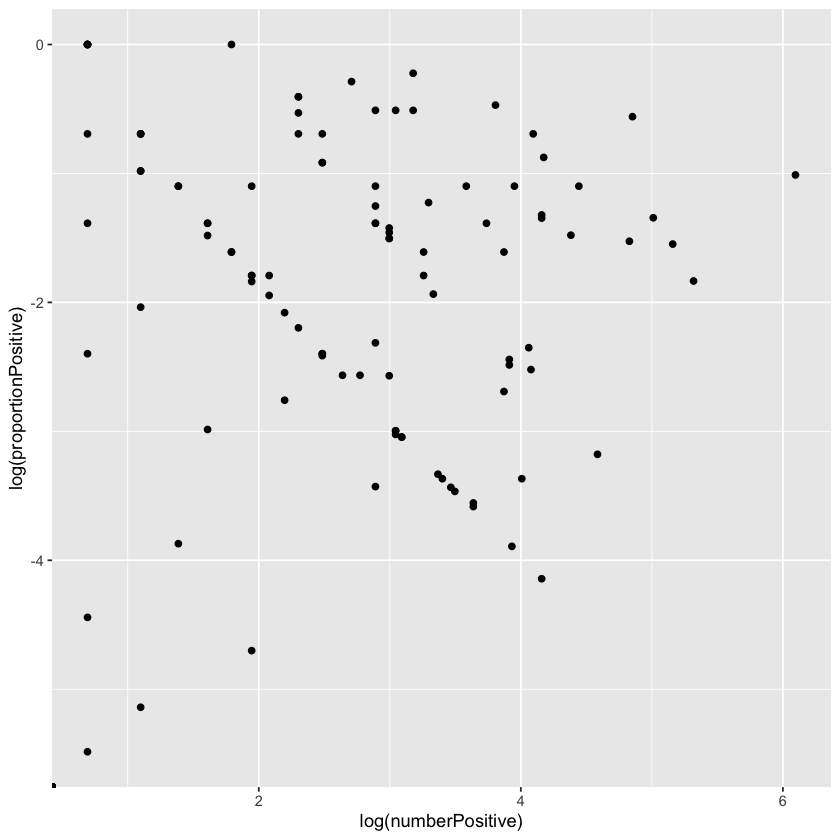

In [12]:
# What is relationship between proportion positive and number positive
tck_borrelia_train %>%
  ggplot() +geom_point(aes(x=log(numberPositive), y=log(proportionPositive)))

What proportion of nymphs were tested in each sample? We expect a 1:1 line below if all nymphs were tested within each sample.


There are a few samples where they did not test ALL the nymphs. If we inspect these (below), we see that only HARV_004 is concerning, since all the others are missing less than 3 nymphs in their testing.

In [14]:
# Just get rid of all data where they didn't test most nymphs-- see how many that is
tck_borrelia %>%
  filter(abs(nNymph-numberTested)>0) %>% select(plotID, collectDate, nNymph, numberTested)
# Most of these samples are not a problem, except HARV_004 (2015) and maybe SCI_002 (2017) and SERC_001 (2017-07). 
# Let's get rid of only HARV_004; I think all the rest are fine.
tck_borrelia_adj <- tck_borrelia %>%
  filter(abs(nNymph-numberTested)<3) # HARV_004 is the only site that differs nNymph and numberTested by more than 3


plotID   collectDate       nNymph numberTested
1  HARV_004 2015-07-13T18:22Z 1451      2        
2  BLAN_005 2016-05-16T15:37Z  577    575        
3  BLAN_005 2017-06-01T17:59Z 1222   1221        
4  BLAN_005 2017-06-19T14:51Z  158    156        
5  SCBI_002 2016-05-31T14:40Z  241    240        
6  SCBI_002 2017-07-03T16:34Z    7      6        
7  SCBI_007 2017-05-31T17:32Z   13     12        
8  SCBI_013 2017-07-26T17:29Z  483    482        
9  SERC_001 2017-06-28T15:00Z   31     30        
10 SERC_001 2017-07-17T20:38Z    7      6        
11 SERC_002 2017-04-27T18:58Z    3      2        
12 SERC_002 2017-08-09T17:57Z   29     28        
13 SERC_005 2016-06-14T14:38Z   56     54        
14 SERC_005 2017-06-30T12:09Z   29     28        
15 SERC_005 2017-07-17T18:56Z   25     24        
16 SERC_006 2016-05-25T12:27Z   18     15        
17 SERC_006 2017-06-12T15:10Z  341    340        
18 SERC_006 2017-08-09T16:33Z    3      2        
19 SERC_012 2016-06-13T18:25Z   24     21        
20 SERC_012 2017-05-18T23:10Z  133    132        
21 SERC_012 2017-06-29T21:15Z   25     24        
22 OSBS_005 2016-03-30T13:40Z 3578   3577        
23 TREE_019 2016-06-27T17:45Z  576    575        
24 ORNL_002 2016-07-13T14:40Z   31     30        
25 ORNL_002 2017-05-03T14:15Z  133    132        
26 ORNL_007 2014-07-16T16:50Z  183    182        
27 ORNL_007 2016-06-03T15:00Z   73     72        
28 ORNL_007 2016-07-13T04:53Z 1600   1599        
29 ORNL_007 2017-04-13T16:05Z   19     18        
30 ORNL_007 2017-05-26T19:11Z   43     42        
31 ORNL_007 2017-07-03T16:07Z   91     90        
32 ORNL_007 2017-08-01T16:44Z   21     20        
33 ORNL_008 2014-06-26T15:32Z 4033   4032        
34 ORNL_008 2017-05-26T17:25Z  183    182        
35 ORNL_040 2017-08-01T13:19Z  625    624        
36 TALL_008 2016-04-20T15:23Z  871    870

## Inspecting possible predictors of borrelia

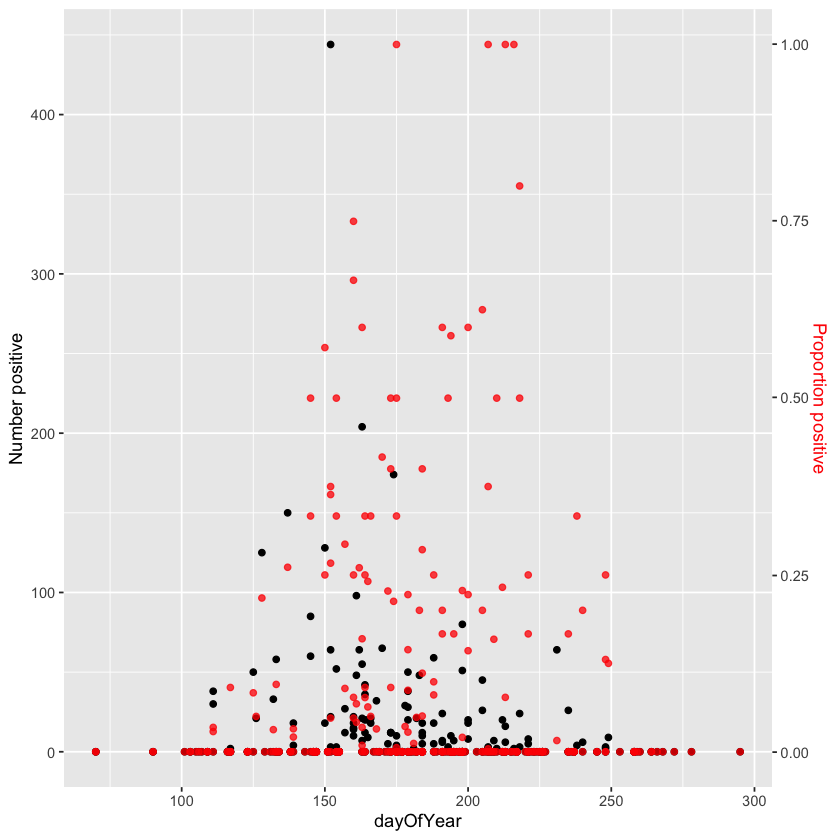

In [15]:
# dayOfYear vs borrelia
tck_borrelia_adj %>%
  ggplot() +geom_point(aes(x=dayOfYear, y=numberPositive))+
  geom_point(aes(x=dayOfYear, y=proportionPositive*max(tck_borrelia_adj$numberPositive)), col="red", alpha=0.75) +
  scale_y_continuous(sec.axis=sec_axis(trans=~./max(tck_borrelia_adj$numberPositive), name="Proportion positive"))+
  theme(axis.title.y.right = element_text(color="red")) + ylab("Number positive") 


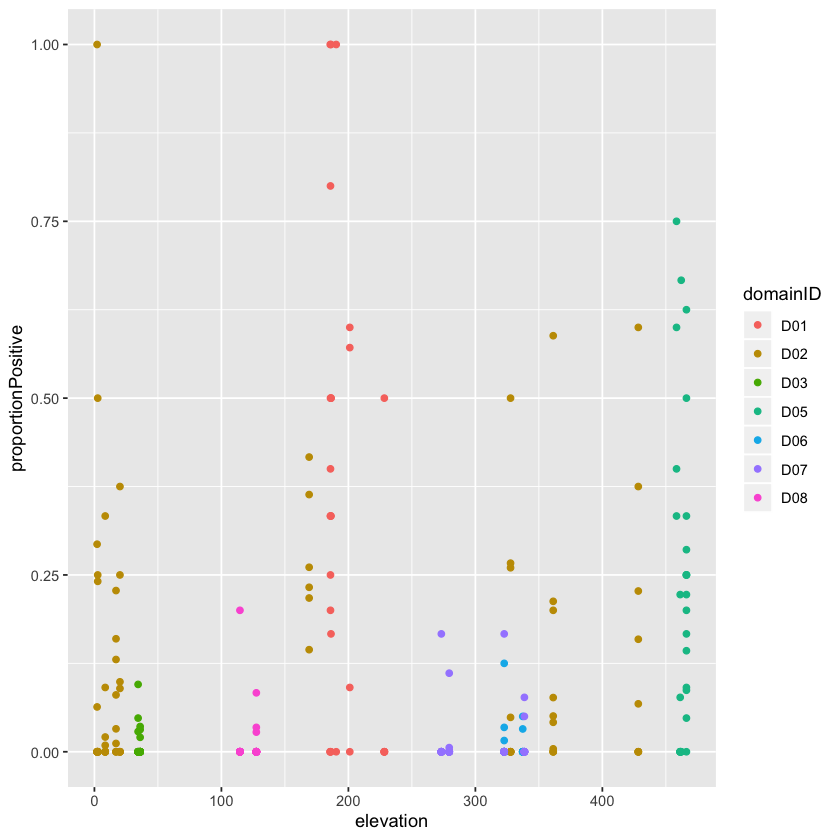

In [16]:
# elevation vs borrelia
tck_borrelia_adj %>%
  ggplot() +geom_point(aes(x=elevation, y=proportionPositive, col=domainID))


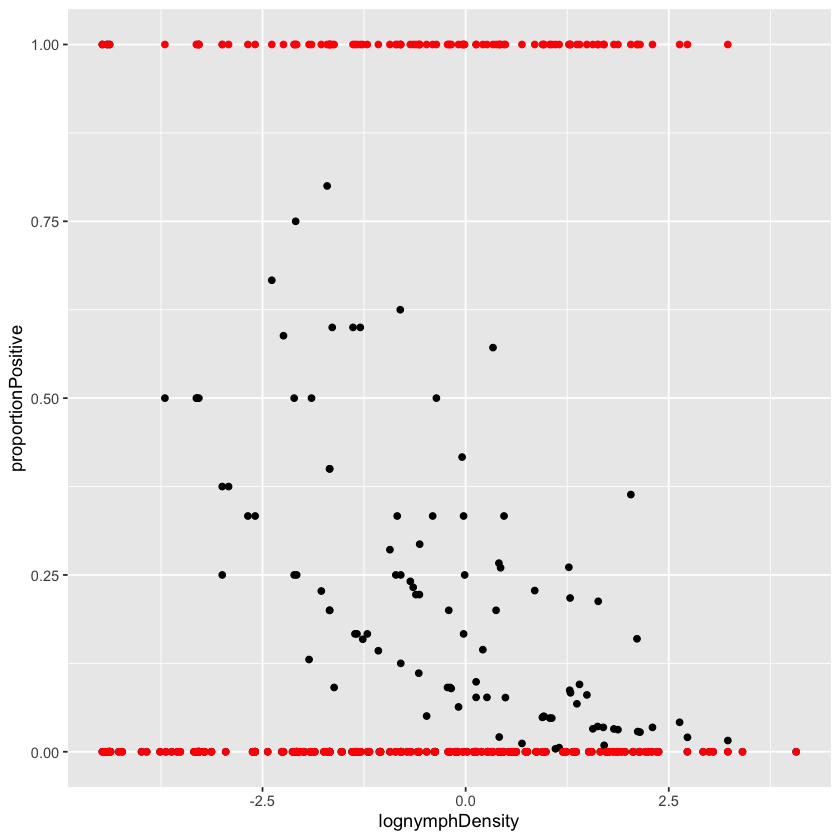

In [17]:
# nymph density vs borrelia
tck_borrelia_adj %>%
  ggplot() +geom_point(aes(x=lognymphDensity, y=proportionPositive)) +
  geom_point(aes(x=lognymphDensity, y=borrPresent), col="red")


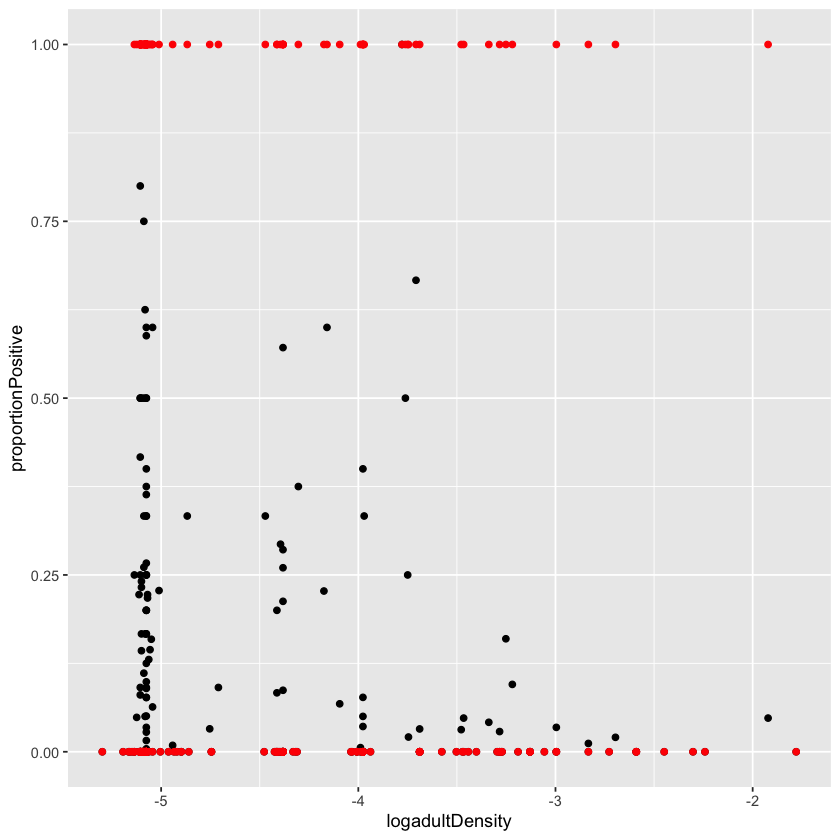

In [18]:
# adult density vs borrelia
tck_borrelia_adj %>%
  ggplot() +geom_point(aes(x=logadultDensity, y=proportionPositive)) +
  geom_point(aes(x=logadultDensity, y=borrPresent), col="red")


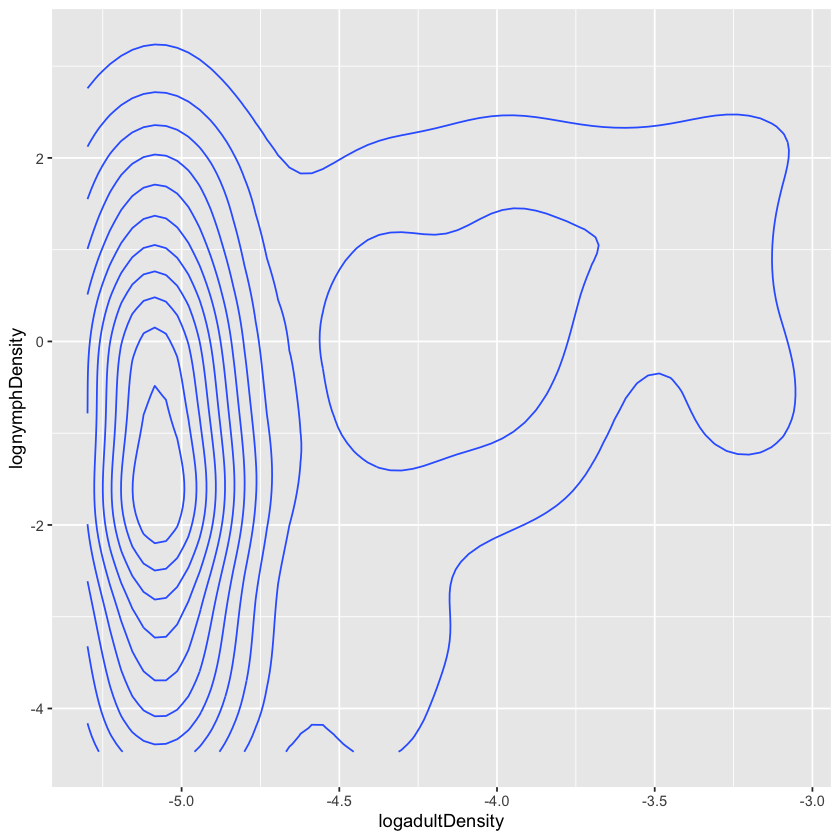

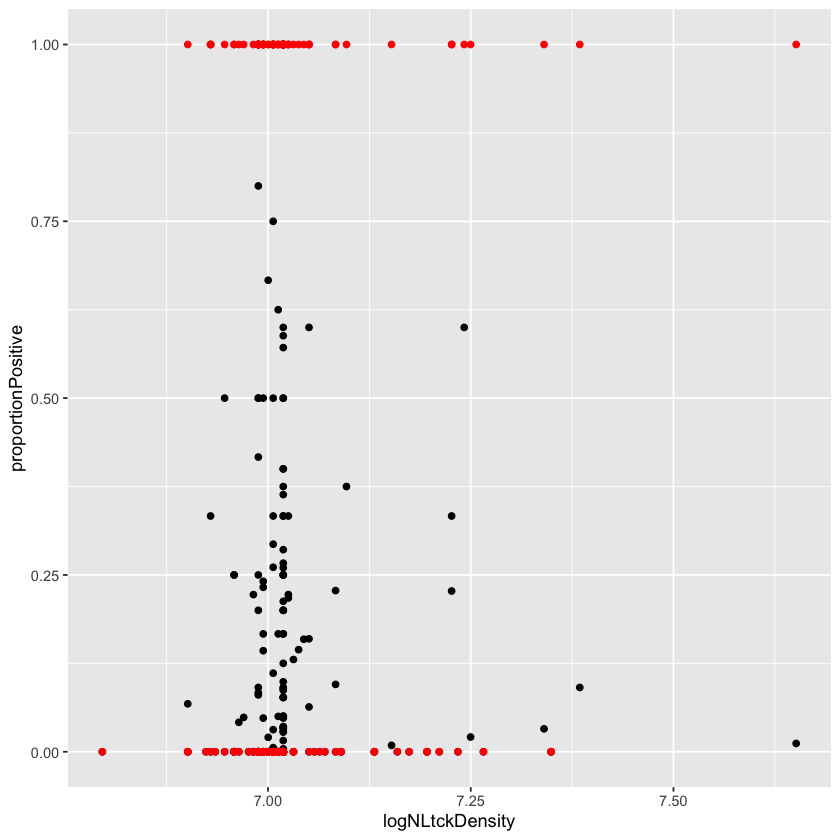

In [19]:
# nymph and adult density vs borrelia-- first, are they correlated?
tck_borrelia_adj %>%
  ggplot() + geom_density2d(aes(x=logadultDensity, y=lognymphDensity))
tck_borrelia_adj %>%
  ggplot() +geom_point(aes(x=logNLtckDensity, y=proportionPositive)) +
  geom_point(aes(x=logNLtckDensity, y=borrPresent), col="red")


## Subsetting data into training and testing sets

## Fitting a two-step GAM

Because the data are zero-inflated, we are going to do a two-part model first to prevent issues with convergence. First, we fit a GAM to the binomial component of the data. Additionally, we are going to do model selection here using a custom script

In [20]:
stepGAM <- function(dat, predictors, response, constant_pred=NULL, family, ignore.combos) {
  ## For troubleshooting
  # dat <- tck_borrelia_adj
  # predictors = allPred
  # response = "borrPresent"
  # constant_pred <- "offset(log(numberTested))"
  # family=binomial
  # ignore.combos=list(c("domainID","s(domainID, bs='re')"), c("s(logNLtckDensity)","s(logadultDensity)","s(lognymphDensity)")
  #                    , c("s(logNLtckDensity)","s(logadultDensity)"),c("s(logNLtckDensity)","s(lognymphDensity)"))
  n_rows <- sum(sapply(1:length(predictors),FUN=function(x){ncol(combn(predictors,m=x))} ))
  allAIC <- setNames(data.frame(matrix(nrow=n_rows, ncol=(4+length(predictors)))),nm = c("AIC","REML","Dev.expl","formula",predictors))
  i <- 1
  pb <- txtProgressBar(title = "progress bar", min = 0,
                       max = n_rows, style=3)
  for ( p in 1:length(predictors) ) {
    combos <- combn(predictors, m=p)
    for ( c in 1:ncol(combos) ) {
      # skip any combinations that are meant to be ignored
      if (any(sapply(ignore.combos, FUN=function(ic){sum(ic %in% combos[,c]) == length(ic)}))) {
        i = i + 1
        next
      }
      if ( length(constant_pred)>0 ) {
        frml.temp <- paste(c(paste0(response," ~ ",constant_pred),combos[,c]), collapse="+")
      } else {
        frml.temp <- paste0(paste0(response," ~ "),paste(combos[,c], collapse=" + "), sep="")
      }
      # If more coefficients than data
      res <- try(gam(as.formula(frml.temp)
              , data=dat
              , method="REML"
              , family=family))
      if ( inherits(res, "try-error") ) {
        next
      } else {
        gam.temp <- gam(as.formula(frml.temp)
                        , data=dat
                        , method="REML"
                        , family=family)
        
        pred.temp <- (colnames(allAIC) %in% combos[,c])[-c(1,2,3,4)]
        allAIC[i,c("AIC","REML","Dev.expl","formula")]  <- as.vector(c(gam.temp$aic,gam.temp$gcv.ubre[1],summary(gam.temp)$dev.expl,frml.temp))
        allAIC[i, predictors] <- pred.temp
        
      }
      
      i <- i+1
      Sys.sleep(0.1)
      setTxtProgressBar(pb, i, label=paste( round(i/total*100, 0),
                                            "% done"))
    }
  }
  close(pb)
  return(allAIC)
}

## GAM Part I: binomial hurdle component

In [21]:
# First, model a binomial component with dayOfYear, nlcdClass, and non-larval tick density (NLtckDensity) as predictors of borrellia presence/absence.
# Plot is a random effect, which I include as a varying-intercept, varying-slope model.
allPred <- c("s(dayOfYear)","nlcdClass","s(elevation)"
             ,"s(logNLtckDensity)","s(logadultDensity)","s(lognymphDensity)"
             ,"s(plotID, bs='re')", "s(plotID, dayOfYear, bs='re')"
             ,"s(year, bs='re')", "s(year, dayOfYear, bs='re')"
             , "domainID", "s(domainID, bs='re')"
)


if (FALSE) {
  allAIC <- stepGAM(dat = tck_borrelia_adj, predictors = allPred, response = "borrPresent", constant_pred = "offset(log(numberTested))", family = binomial, ignore.combos=list(c("domainID","s(domainID, bs='re')"), c("s(logNLtckDensity)","s(logadultDensity)","s(lognymphDensity)")                                                                                                                                                                 , c("s(logNLtckDensity)","s(logadultDensity)"),c("s(logNLtckDensity)","s(lognymphDensity)")))
  allAIC_filt <- allAIC %>% filter(!is.na(AIC)) %>% arrange(AIC) %>%mutate(rank=seq(1:length(AIC))) %>% 
    mutate(AIC=as.numeric(AIC)
           , Dev.expl = as.numeric(Dev.expl)
           , REML = as.numeric(REML)) %>%
    filter(AIC<500)
  save(allAIC, file="allAIC.RData")
  save(allAIC_filt, file="allAIC.RData")
  
} else {
  load("allAIC.RData")
  load("allAIC_filt.RData")
  
}
summary(allAIC_filt)

      AIC             REML          Dev.expl         formula         
 Min.   :268.8   Min.   :121.5   Min.   :0.05996   Length:1912       
 1st Qu.:272.5   1st Qu.:130.0   1st Qu.:0.51810   Class :character  
 Median :276.8   Median :143.1   Median :0.53339   Mode  :character  
 Mean   :283.9   Mean   :142.9   Mean   :0.52013                     
 3rd Qu.:284.7   3rd Qu.:150.4   3rd Qu.:0.53978                     
 Max.   :492.8   Max.   :247.4   Max.   :0.57577                     
 s(dayOfYear)    nlcdClass       s(elevation)    s(logNLtckDensity)
 Mode :logical   Mode :logical   Mode :logical   Mode :logical     
 FALSE:952       FALSE:952       FALSE:952       FALSE:1532        
 TRUE :960       TRUE :960       TRUE :960       TRUE :380         
                                                                   
                                                                   
                                                                   
 s(logadultDensity) s(lognymphDens

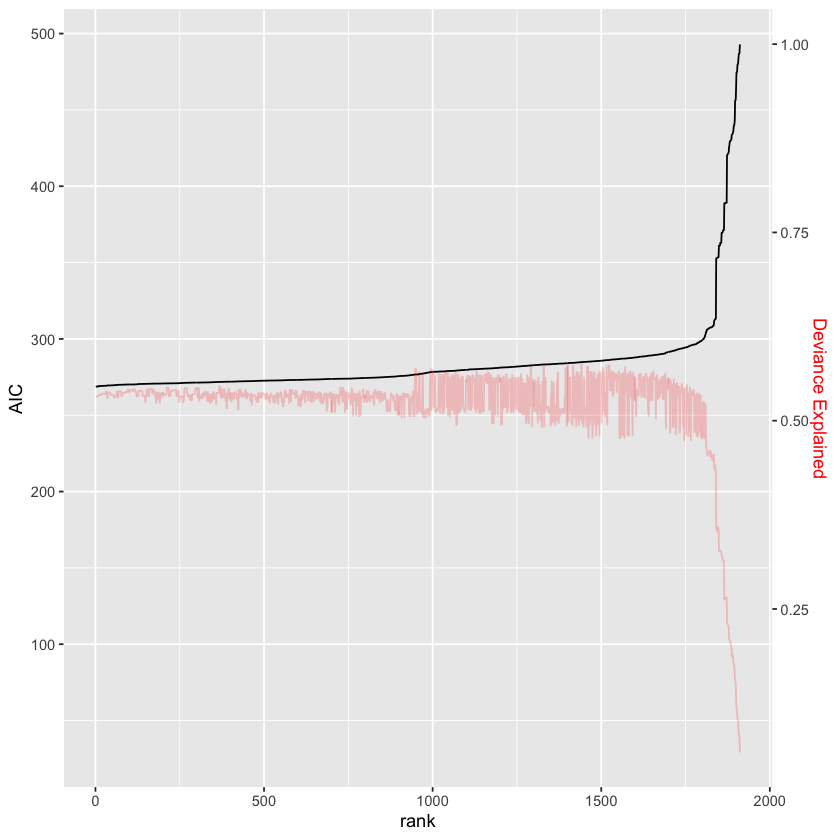

In [22]:
# Let's see distribution of AIC values
allAIC_filt %>% 
  ggplot() +geom_line(aes(x=rank, y=AIC))+
  geom_line(aes(x=rank, y=Dev.expl*(max(allAIC_filt$AIC))), col="red", alpha=0.2) + scale_y_continuous(sec.axis=sec_axis(~./(max(allAIC_filt$AIC)), name="Deviance Explained")) +
  theme(axis.title.y.right = element_text(colour = "red"))


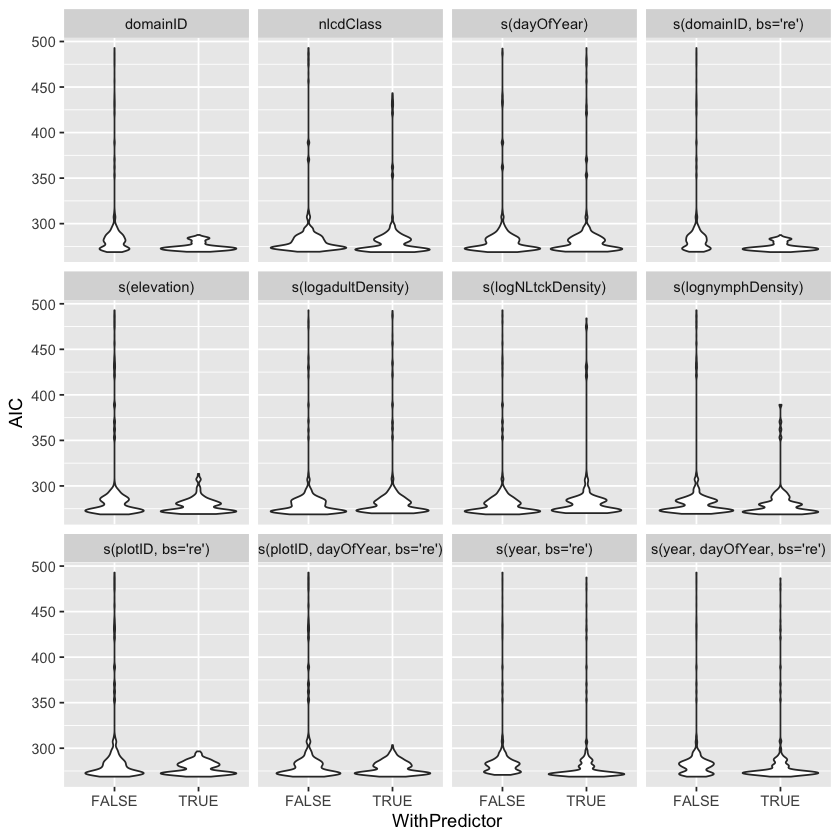

In [23]:
# Compare AIC for models with and without each predictor
allAIC_filt %>% gather(-c(AIC, REML, Dev.expl, formula,rank), key=Predictor, value=WithPredictor) %>% 
  select(AIC, REML, Dev.expl, Predictor, WithPredictor) %>%
  mutate(WithPredictor = ifelse(WithPredictor==0, FALSE, TRUE)) %>%
  ggplot() + geom_violin(aes(x=WithPredictor, y=AIC))  +  facet_wrap(.~Predictor) 


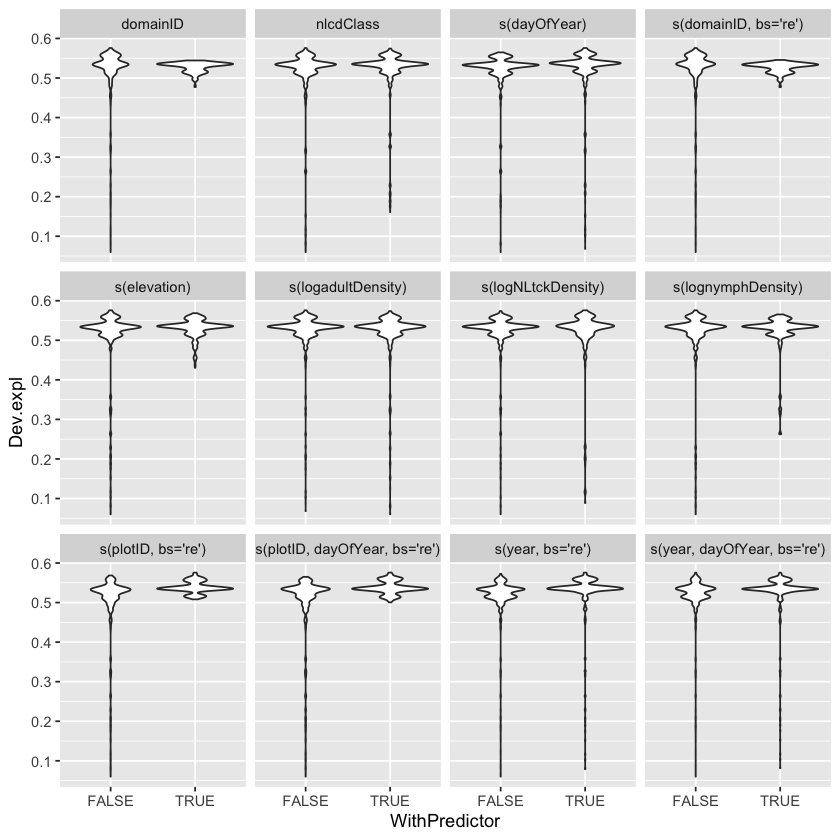

In [24]:
# Compare deviance explained for models with and without each predictor
allAIC_filt %>% gather(-c(AIC, REML, Dev.expl, formula,rank), key=Predictor, value=WithPredictor) %>% 
  select(AIC, REML, Dev.expl, Predictor, WithPredictor) %>%
  mutate(WithPredictor = ifelse(WithPredictor==0, FALSE, TRUE)) %>%
  ggplot() + geom_violin(aes(x=WithPredictor, y=Dev.expl))  +  facet_wrap(.~Predictor) 



Family: binomial 
Link function: logit 

Formula:
borrPresent ~ offset(log(numberTested)) + nlcdClass + s(lognymphDensity) + 
    s(year, bs = "re") + s(domainID, bs = "re")

Parametric coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -7.006      1.315  -5.327 9.98e-08 ***
nlcdClassdeciduousForest    1.646      1.192   1.381   0.1673    
nlcdClassevergreenForest    2.446      1.187   2.061   0.0393 *  
nlcdClassmixedForest        3.479      1.441   2.414   0.0158 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                     edf Ref.df Chi.sq  p-value    
s(lognymphDensity) 1.620  2.031  9.505  0.00876 ** 
s(year)            1.992  3.000 12.816  0.01532 *  
s(domainID)        5.440  6.000 98.638 6.51e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.422   Deviance explained = 53.2%
-REML = 135.94  Scale est. = 1    


Method: REML   Optimizer: outer newton
full convergence after 6 iterations.
Gradient range [-3.554992e-08,2.784288e-09]
(score 135.9381 & scale 1).
Hessian positive definite, eigenvalue range [0.1164156,2.4317].
Model rank =  24 / 24 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                     k'  edf k-index p-value
s(lognymphDensity) 9.00 1.62     1.1    0.96
s(year)            4.00 1.99      NA      NA
s(domainID)        7.00 5.44      NA      NA


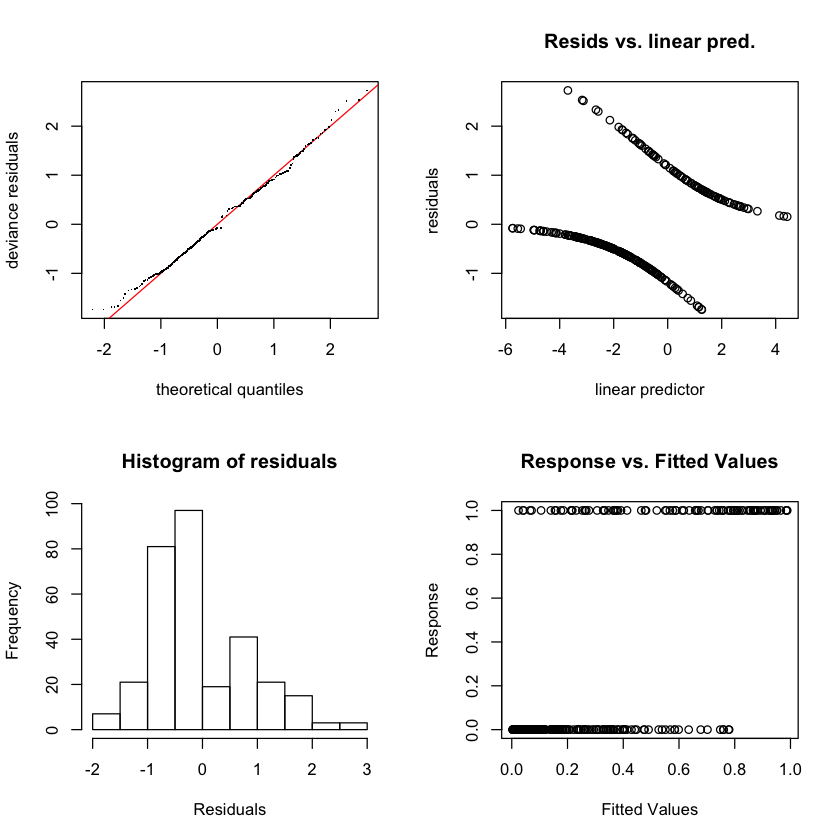

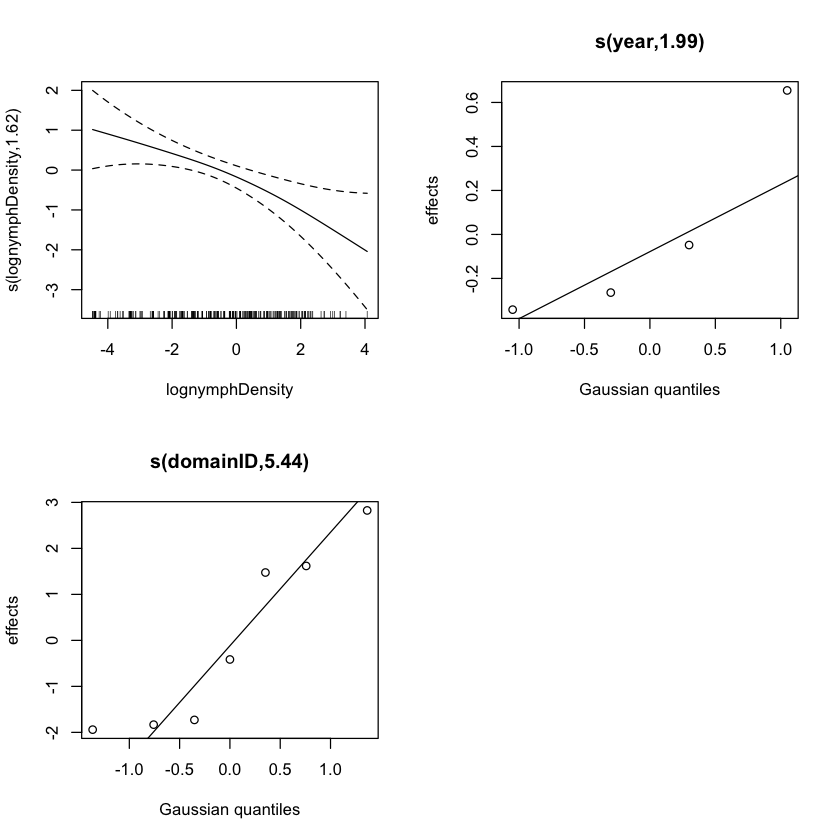

In [25]:
frml_bin1_bestAIC <- allAIC_filt[allAIC_filt$AIC==min(allAIC_filt$AIC),"formula"]
frml_bin1_bestDevexpl <- allAIC_filt[allAIC_filt$Dev.expl==max(allAIC_filt$Dev.expl),"formula"]

# Look at the model with the best AIC value
mod.gambin_bestAIC <- gam(as.formula(frml_bin1_bestAIC)
                      # , offset=log(numberTested) # I include the offset in the formula instead, so that it is included in predictions. Including it here does NOT incorporate numberTested in predictiosn.
                      , data=tck_borrelia_adj
                      , method="REML"
                      , family=binomial)
summary(mod.gambin_bestAIC)
gam.check(mod.gambin_bestAIC)
plot(mod.gambin_bestAIC, pages=1)


Family: binomial 
Link function: logit 

Formula:
borrPresent ~ offset(log(numberTested)) + s(dayOfYear) + s(logNLtckDensity) + 
    s(plotID, bs = "re") + s(plotID, dayOfYear, bs = "re") + 
    s(year, bs = "re")

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -4.4834     0.6574   -6.82 9.09e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                       edf Ref.df  Chi.sq p-value   
s(dayOfYear)         1.199  1.367   6.467 0.01536 * 
s(logNLtckDensity)   1.000  1.000   1.347 0.24601   
s(plotID)           13.525 29.000 276.439 0.13697   
s(plotID,dayOfYear) 13.597 29.000 398.246 0.01056 * 
s(year)              2.059  3.000  30.804 0.00726 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.451   Deviance explained = 57.6%
-REML =  159.9  Scale est. = 1         n = 308


Method: REML   Optimizer: outer newton
full convergence after 12 iterations.
Gradient range [-5.460174e-05,8.676456e-06]
(score 159.9046 & scale 1).
Hessian positive definite, eigenvalue range [5.459088e-05,4.372841].
Model rank =  83 / 83 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                       k'   edf k-index p-value
s(dayOfYear)         9.00  1.20    0.95    0.17
s(logNLtckDensity)   9.00  1.00    0.98    0.35
s(plotID)           30.00 13.53      NA      NA
s(plotID,dayOfYear) 30.00 13.60      NA      NA
s(year)              4.00  2.06      NA      NA


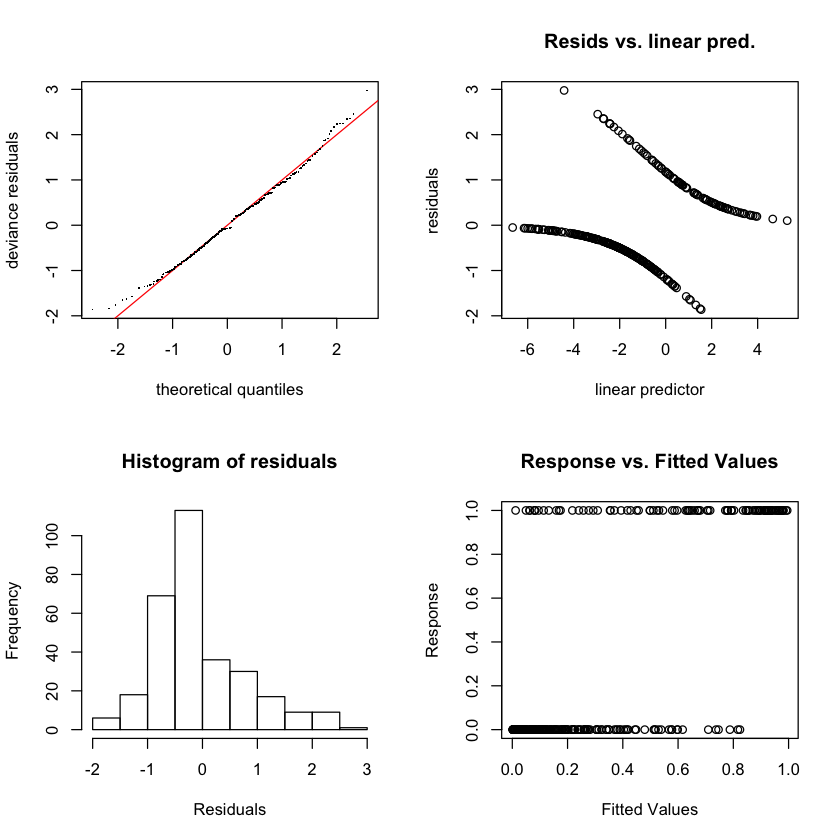

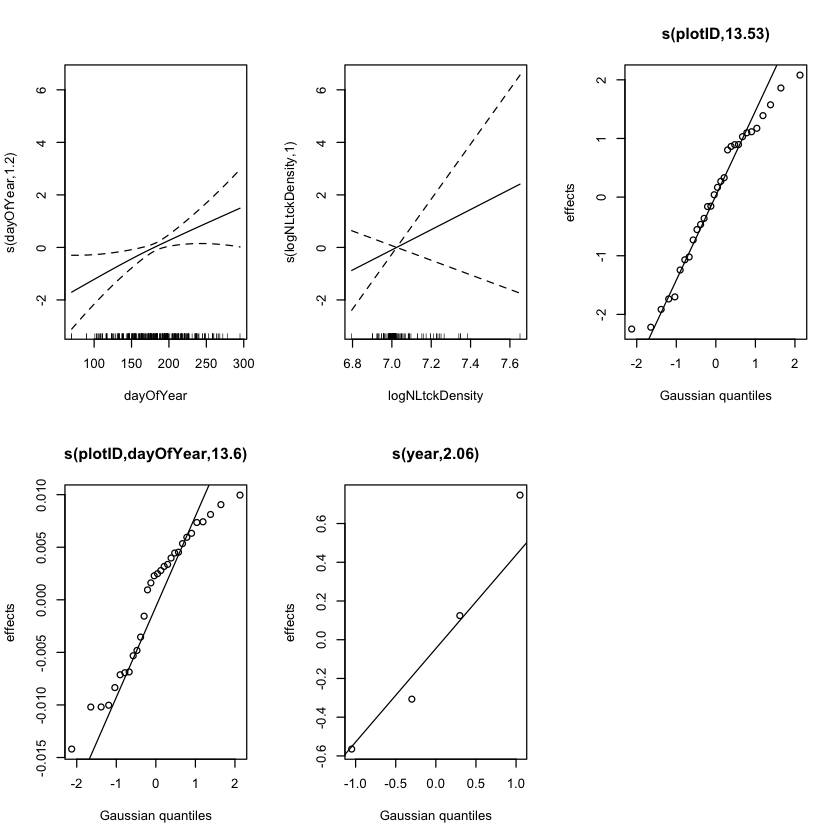

In [26]:
# Look at the model with the best deviance explained
mod.gambin_bestDevExpl <- gam(as.formula(frml_bin1_bestDevexpl)
                          # , offset=log(numberTested) # I include the offset in the formula instead, so that it is included in predictions. Including it here does NOT incorporate numberTested in predictiosn.
                          , data=tck_borrelia_adj
                          , method="REML"
                          , family=binomial)
summary(mod.gambin_bestDevExpl)
gam.check(mod.gambin_bestDevExpl)
plot(mod.gambin_bestDevExpl, pages=1)

In [27]:
# Compare accuracy rate
mean((predict(mod.gambin_bestAIC, type = "response")>0.5) == tck_borrelia_adj$borrPresent)
mean((predict(mod.gambin_bestDevExpl, type = "response")>0.5) == tck_borrelia_adj$borrPresent)


[1] 0.8376623

[1] 0.8506494


Method: REML   Optimizer: outer newton
full convergence after 12 iterations.
Gradient range [-5.460174e-05,8.676456e-06]
(score 159.9046 & scale 1).
Hessian positive definite, eigenvalue range [5.459088e-05,4.372841].
Model rank =  83 / 83 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                       k'   edf k-index p-value
s(dayOfYear)         9.00  1.20    0.95    0.18
s(logNLtckDensity)   9.00  1.00    0.98    0.33
s(plotID)           30.00 13.53      NA      NA
s(plotID,dayOfYear) 30.00 13.60      NA      NA
s(year)              4.00  2.06      NA      NA



Family: binomial 
Link function: logit 

Formula:
borrPresent ~ offset(log(numberTested)) + s(dayOfYear) + s(logNLtckDensity) + 
    s(plotID, bs = "re") + s(plotID, dayOfYear, bs = "re") + 
    s(year, bs = "re")

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -4.4834     0.6574   -6.82 9.09e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                       edf Ref.df  Chi.sq p-value   
s(dayOfYear)         1.199  1.367   6.467 0.01536 * 
s(logNLtckDensity)   1.000  1.000   1.347 0.24601   
s(plotID)           13.525 29.000 276.439 0.13697   
s(plotID,dayOfYear) 13.597 29.000 398.246 0.01056 * 
s(year)              2.059  3.000  30.804 0.00726 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.451   Deviance explained = 57.6%
-REML =  159.9  Scale est. = 1         n = 308

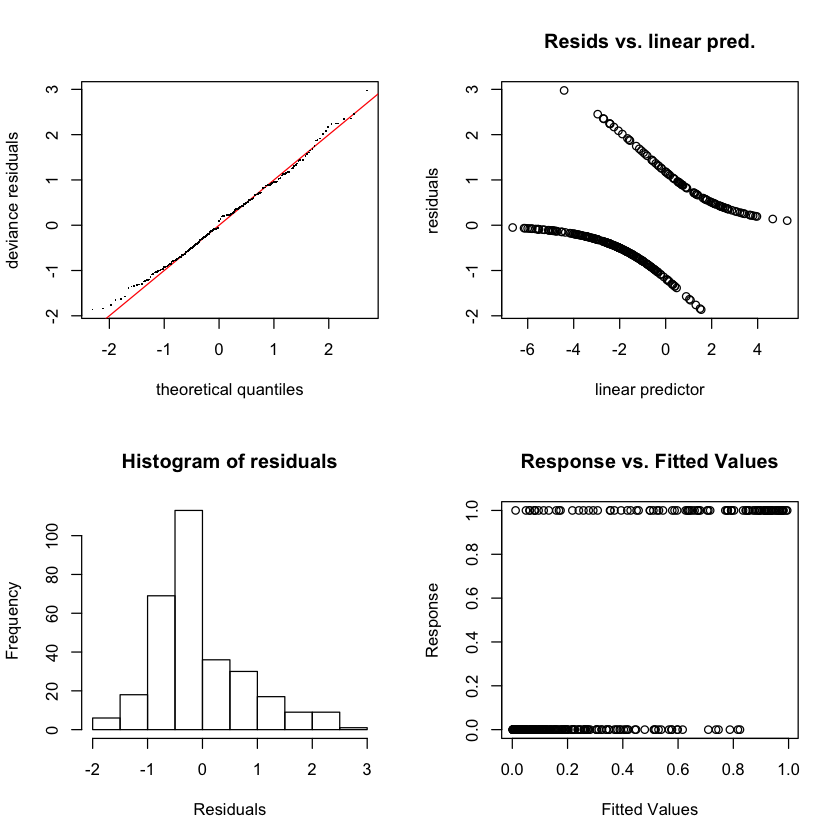

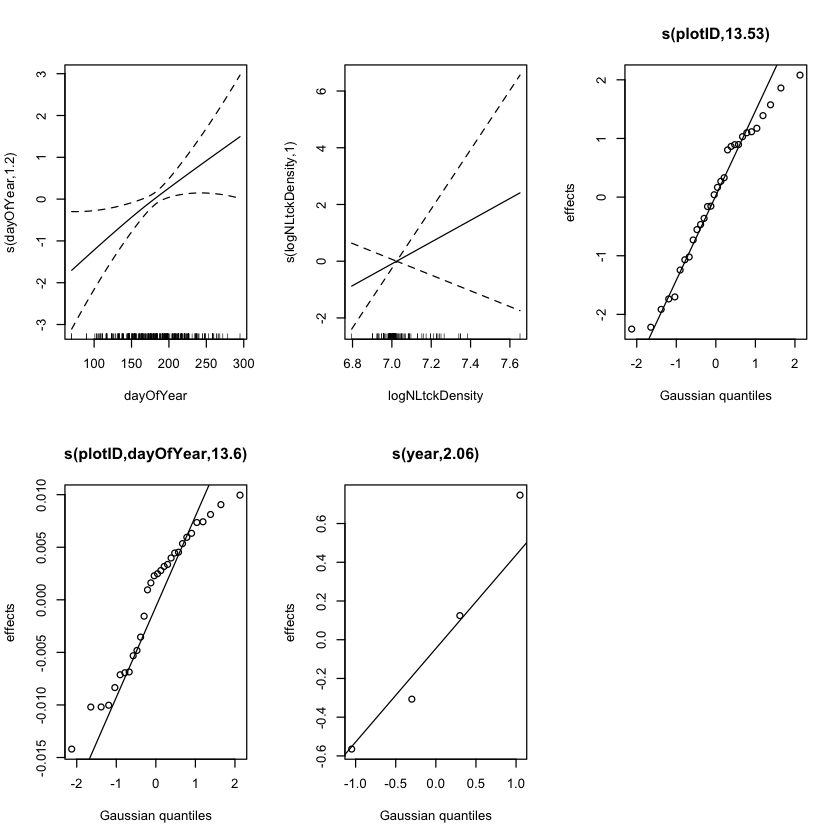

Warning message in predict.gam(x, newdata = newd, se.fit = TRUE, type = type):
“factor levels 2018, 2019 not in original fit”

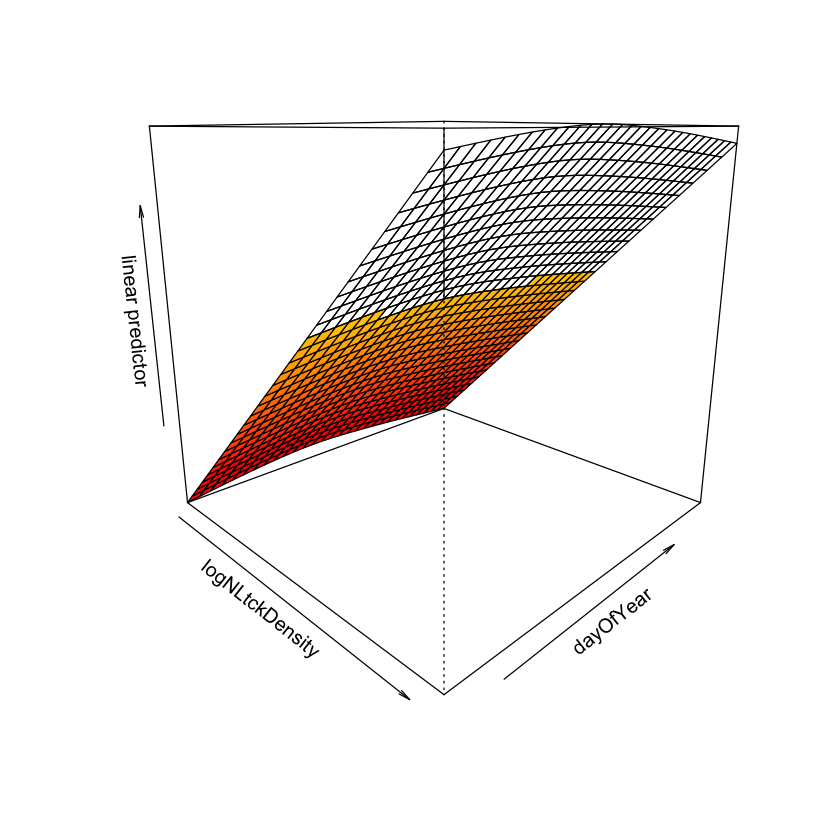

Warning message in predict.gam(x, newdata = newd, se.fit = TRUE, type = type):
“factor levels ABBY_001, ABBY_002, ABBY_003, ABBY_005, ABBY_006, ABBY_023, BARR_021, BARR_030, BARR_031, BARR_034, BARR_037, BARR_084, BART_002, BART_010, BART_011, BART_015, BART_019, BART_029, BLAN_002, BLAN_004, BLAN_008, BLAN_012, BLAN_015, BLAN_020, BONA_002, BONA_004, BONA_012, BONA_013, BONA_020 not in original fit”

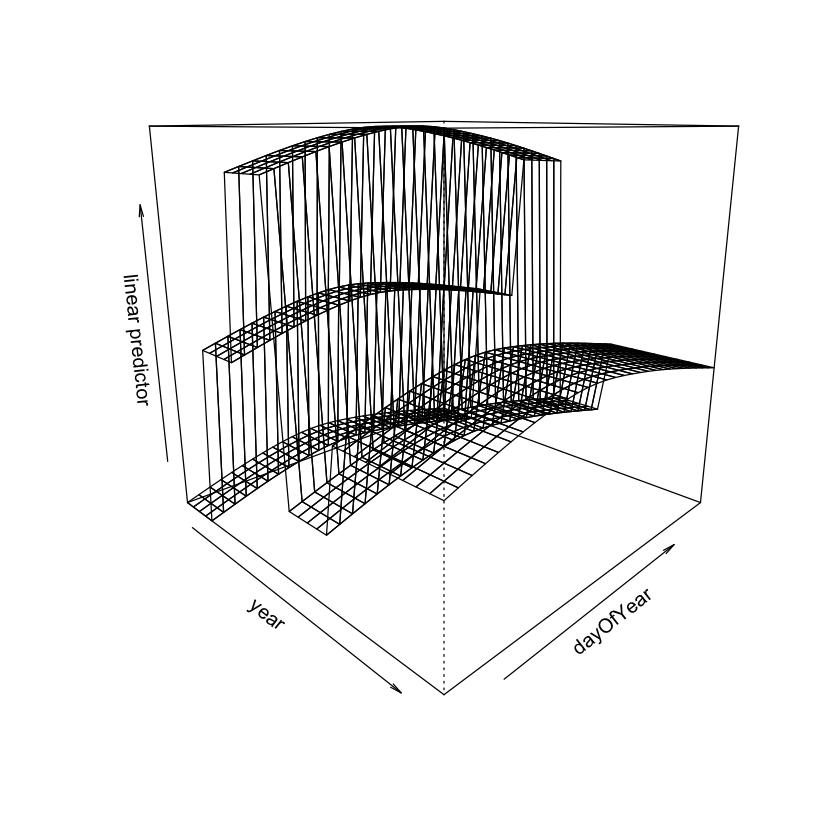

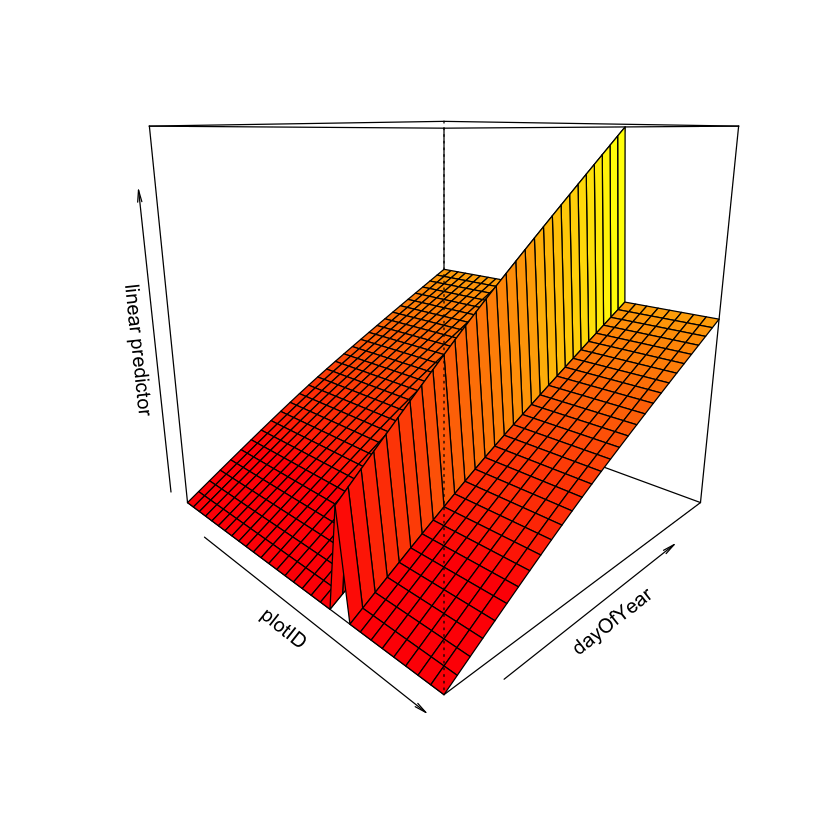

In [28]:
# Honestly, the "deviance explained" looks better and makes more sense, in my opinion.

## FINAL MODEL:
frml.bin1 <- frml_bin1_bestDevexpl
mod.gambin<- gam(as.formula(frml.bin1)
                 # , offset=log(numberTested) # I include the offset in the formula instead, so that it is included in predictions. Including it here does NOT incorporate numberTested in predictiosn.
                 , data=tck_borrelia_adj
                 , method="REML"
                 , family=binomial)
gam.check(mod.gambin)
summary(mod.gambin)
plot(mod.gambin, scale=0, pages=1)
vis.gam(mod.gambin, view = c("logNLtckDensity","dayOfYear"), theta=45)
vis.gam(mod.gambin, view = c("year","dayOfYear"), theta=45)
vis.gam(mod.gambin, view = c("plotID","dayOfYear"), theta=45)


[1] 0.8506494

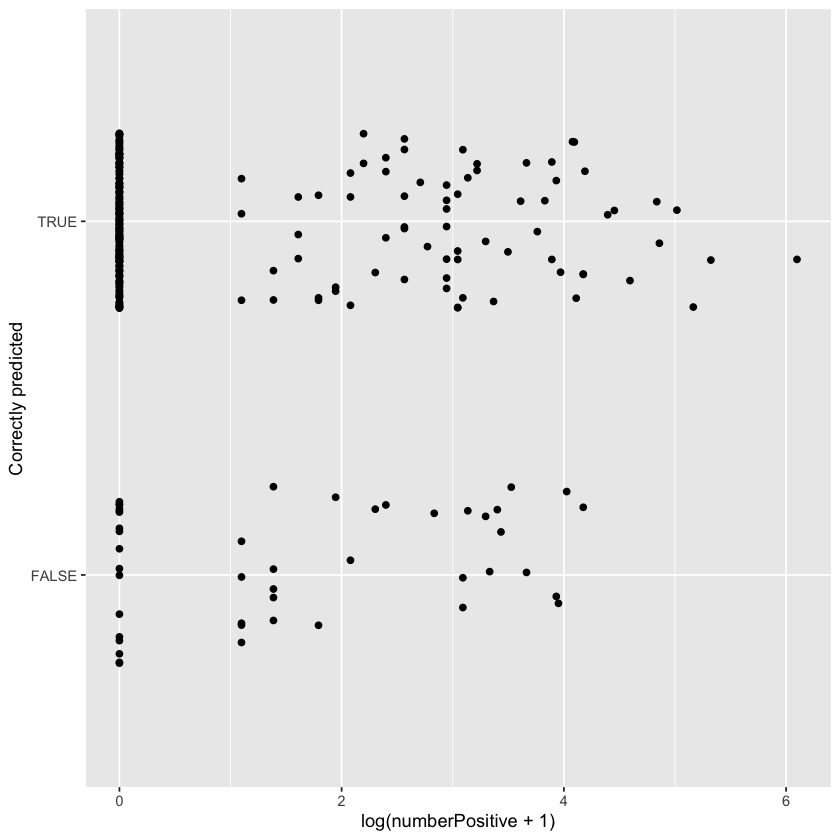

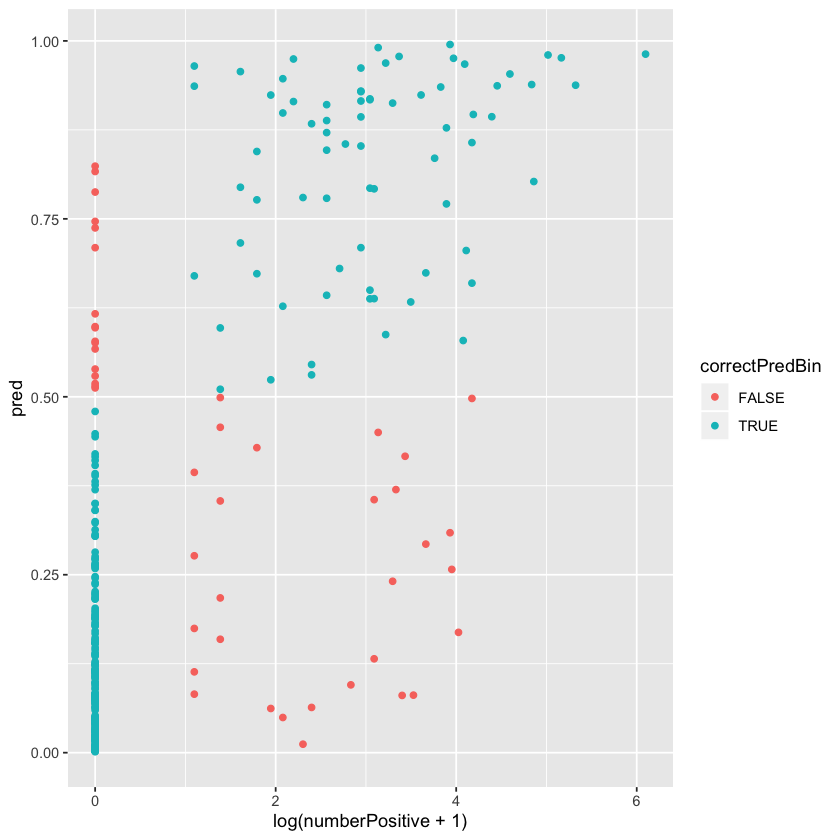

In [29]:
# Proportion of correct predictions
mean((predict(mod.gambin, type = "response")>0.5) == tck_borrelia_adj$borrPresent)

# Of those where they predicted presence/absence incorrectly, how "far" were they off? 
# (i.e. were there are "negative" predictions that actually had a LOT of borrellia?)
tck_borrelia_adj %>%
  mutate(pred =as.numeric(predict(mod.gambin, type="response"))
         ,correctPredBin = ((pred>0.5) == tck_borrelia_adj$borrPresent) ) %>%
  ggplot() +geom_jitter(aes(x=log(numberPositive+1), y=correctPredBin), height=0.25, width=0) + ylab("Correctly predicted")

tck_borrelia_adj %>%
  mutate(pred =as.numeric(plogis(predict(mod.gambin)))
         ,correctPredBin =((pred>0.5) == tck_borrelia_adj$borrPresent) ) %>%
  ggplot() +geom_point(aes(x=log(numberPositive+1), y=pred, col=correctPredBin))


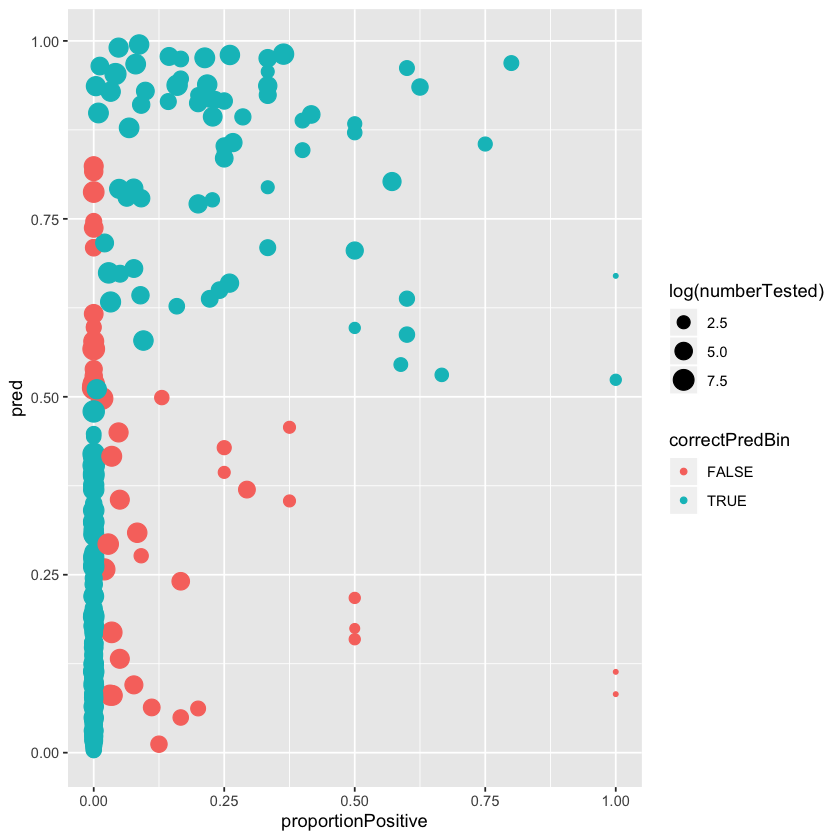

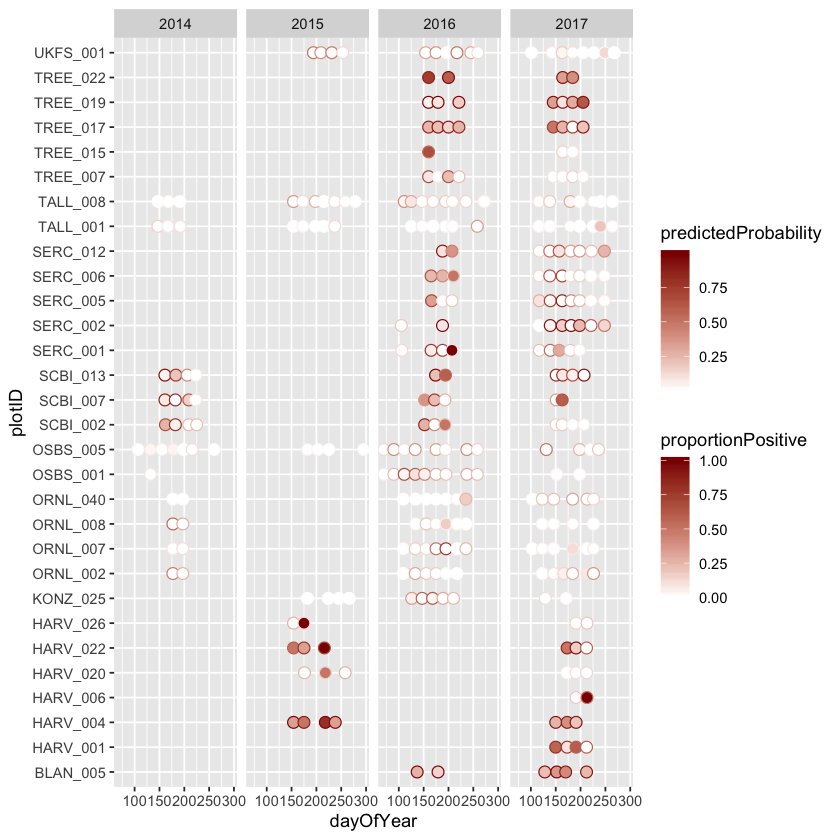

In [30]:
# Ideally, you have a positive, linear correlation between proportion positive and predicted probability. "Errors" should be correlated with small sample size.
tck_borrelia_adj %>%
  mutate(pred =as.numeric(plogis(predict(mod.gambin)))
         ,correctPredBin =((pred>0.5) == tck_borrelia_adj$borrPresent) ) %>%
  ggplot() +geom_point(aes(x=proportionPositive, y=pred, col=correctPredBin, cex=log(numberTested)))

# What are the groups that they least accurately predicted?
tck_borrelia_adj %>%
  mutate(predictedProbability =as.numeric(plogis(predict(mod.gambin)))
         ,correctPredBin =((predictedProbability>0.5) == tck_borrelia_adj$borrPresent) 
         # , proportionPositive = ifelse(proportionPositive==0, NA, proportionPositive)
         ) %>%
  ggplot() + geom_point(aes(x=dayOfYear, y=plotID, fill=proportionPositive, col=predictedProbability), pch=21,cex=3) +
  scale_fill_gradient(low="white", high="darkred") +
  scale_color_gradient(low="white", high="darkred") +
  facet_grid(.~year)

In [31]:
# Is there a bias for predicting negative or positive results?
tck_borrelia_adj %>%
  mutate(predictedProbability =as.numeric(plogis(predict(mod.gambin)))
         , predictedPA = (predictedProbability>0.5)
         ,correctPredBin =((predictedProbability>0.5) == tck_borrelia_adj$borrPresent) ) %>%
  select(borrPresent,predictedPA) %>% table()
17/(189+17) # False positive rate
29/(73+29) # False negative rate
# The false negative rate is actually a lot higher than the false positive rate. 
# This means, on average, more samples are positive then you'd expect, given the model.


           predictedPA
borrPresent FALSE TRUE
          0   189   17
          1    29   73

[1] 0.08252427

[1] 0.2843137

In [32]:
## So finally, we need to filter the dataset by the predicted "absent" and fit a poisson or negative binomial model
# To include the maximum amount of samples as possible, I'm going to filter the dataset sort of un-usually--
# First, I am going to keep all positive borrelia results. Then, for each "negative" borrelia result, 
# I will look at the predicted probability in our model and determine whether it is a "binomial/hurdle" negative, or a "poisson/NB" negative.

tck_borrelia_filtBin <- tck_borrelia_adj %>%
  mutate(pred=predict(mod.gambin, type="response")) %>%
  filter((borrPresent>0 | pred > 0.5))

# Double check I did the filtering correctly
tck_borrelia_filtBin %>%
  mutate(predictedPA = (pred > 0.5)) %>%
  select(borrPresent,predictedPA) %>% table()


           predictedPA
borrPresent FALSE TRUE
          0     0   17
          1    29   73

In [33]:

# make year a factor
tck_borrelia_filtBin <- tck_borrelia_filtBin %>%
  mutate(year=factor(year))

## GAM Part II: the second GAM model for abundance

In [34]:
### Try the whole model section process again with a binomial
# I'm increasing spline smoothness here, because the AIC values change drastically when I don't include them
allPred2 <- c("s(dayOfYear)","nlcdClass","s(elevation)"
             ,"s(logNLtckDensity, sp=1)","s(logadultDensity, sp=1)","s(lognymphDensity, sp=1)"
             ,"s(plotID, bs='re')", "s(plotID, dayOfYear, bs='re')"
             ,"s(year, bs='re')", "s(year, dayOfYear, bs='re')"
             , "domainID", "s(domainID, bs='re')"
)
if ( FALSE ) {
  allAIC_2 <- stepGAM(dat=tck_borrelia_filtBin, predictors = allPred2, response = "cbind(numberPositive,numberTested)", family = binomial, ignore.combos=list(c("domainID","s(domainID, bs='re')")
                                                                                                                                                              , c("s(logNLtckDensity, sp=1)","s(logadultDensity, sp=1)","s(lognymphDensity, sp=1)")
                                                                                                                                                              , c("s(logNLtckDensity, sp=1)","s(lognymphDensity, sp=1)")
                                                                                                                                                              , c("s(logNLtckDensity, sp=1)","s(logadultDensity, sp=1)")
                                                                                                                                                              ))
  allAIC_2_filt <- allAIC_2 %>% filter(!is.na(AIC)) %>% arrange(AIC) %>%mutate(rank=seq(1:length(AIC))) %>% 
    mutate(AIC=as.numeric(AIC)
           , Dev.expl = as.numeric(Dev.expl)
           , REML = as.numeric(REML)) %>%
    filter(AIC<2000)
  save(allAIC_2, file="allAIC_2.RData")
  save(allAIC_2_filt, file="allAIC_2_filt.RData")
  } else {
  load("allAIC_2.RData")
  load("allAIC_2_filt.RData")
}
summary(allAIC_2)

     AIC                REML             Dev.expl           formula         
 Length:4095        Length:4095        Length:4095        Length:4095       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
 s(dayOfYear)    nlcdClass       s(elevation)    s(logNLtckDensity, sp=1)
 Mode :logical   Mode :logical   Mode :logical   Mode :logical           
 FALSE:959       FALSE:959       FALSE:959       FALSE:1535              
 TRUE :960       TRUE :960       TRUE :960       TRUE :384               
 NA's :2176      NA's :2176      NA's :2176      NA's :2176              
 s(logadultDensity, sp=1) s(lognymphDensity, sp=1) s(plotID, bs='re')
 Mode :logical            Mode :logical            Mode :logical     
 FALSE:1151               FALSE:1151               FALSE:959         
 TRUE :768                TRUE :768

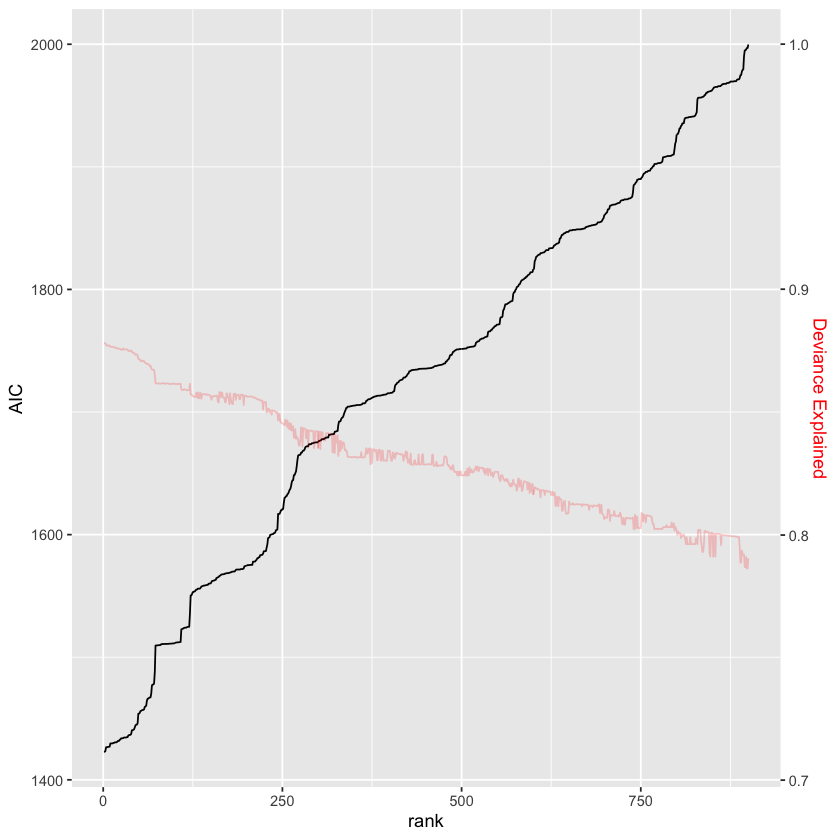

In [35]:

# Let's see distribution of AIC values
allAIC_2_filt %>% 
  ggplot() +geom_line(aes(x=rank, y=AIC))+
  geom_line(aes(x=rank, y=Dev.expl*(max(allAIC_2_filt$AIC))), col="red", alpha=0.2) + scale_y_continuous(sec.axis=sec_axis(~./(max(allAIC_2_filt$AIC)), name="Deviance Explained")) +
  theme(axis.title.y.right = element_text(colour = "red"))


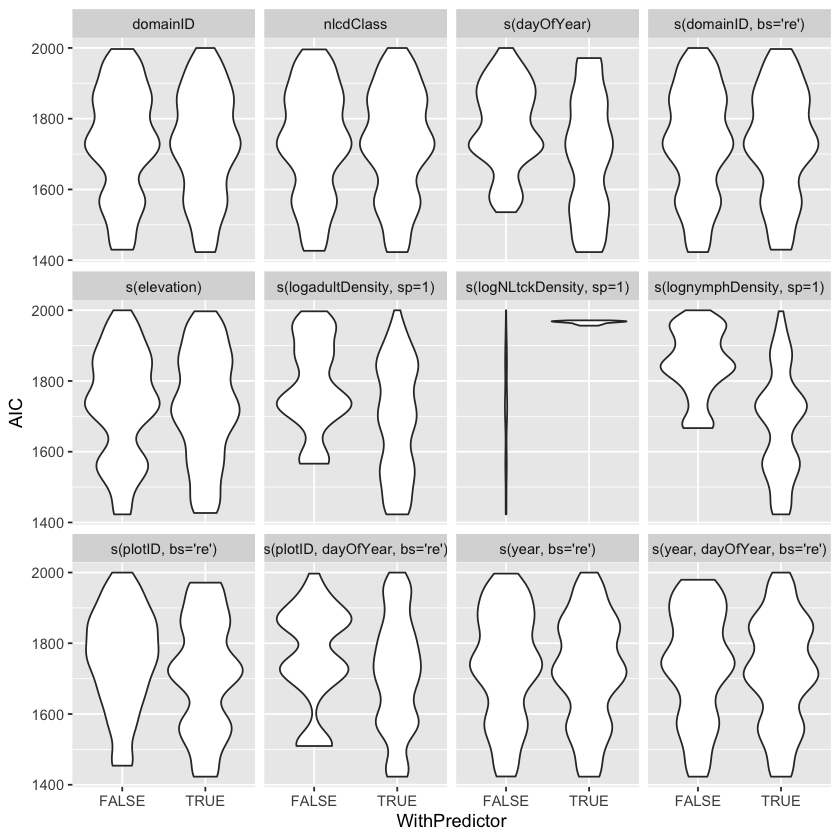

In [36]:
# Compare AIC for models with and without each predictor
allAIC_2_filt %>% gather(-c(AIC, REML, Dev.expl, formula, rank), key=Predictor, value=WithPredictor) %>%
  select(AIC, REML, Dev.expl, Predictor, WithPredictor) %>%
  mutate(WithPredictor = ifelse(WithPredictor==0, FALSE, TRUE)) %>%
  ggplot() + geom_violin(aes(x=WithPredictor, y=AIC))  +  facet_wrap(.~Predictor)


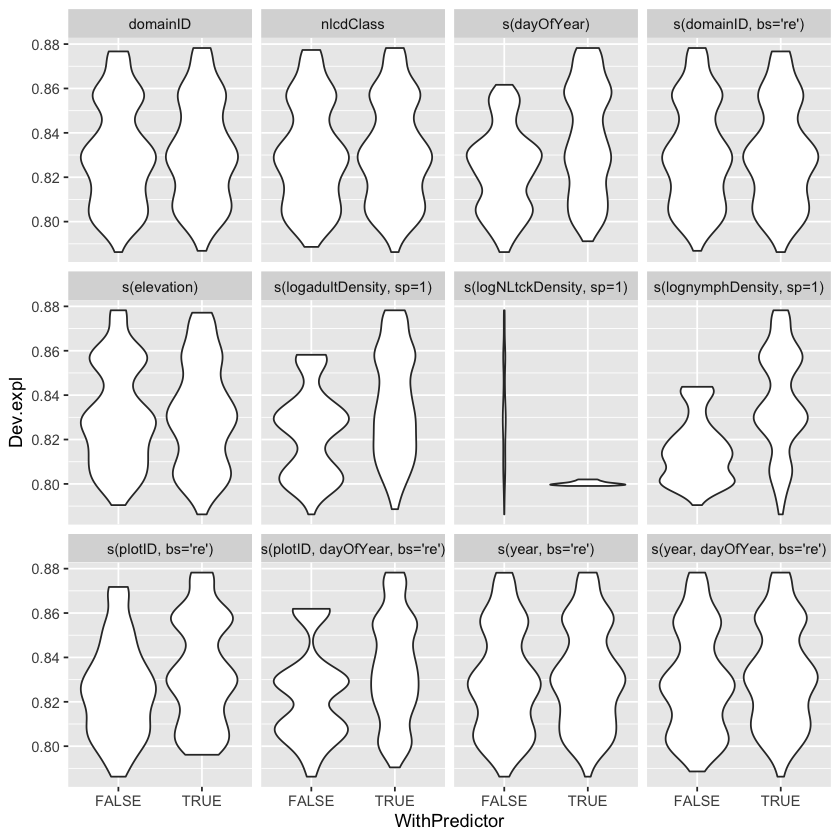

In [37]:
# Compare deviance explained for models with and without each predictor
allAIC_2_filt %>% gather(-c(AIC, REML, Dev.expl, formula,rank), key=Predictor, value=WithPredictor) %>%
  select(AIC, REML, Dev.expl, Predictor, WithPredictor) %>%
  mutate(WithPredictor = ifelse(WithPredictor==0, FALSE, TRUE)) %>%
  ggplot() + geom_violin(aes(x=WithPredictor, y=Dev.expl))  +  facet_wrap(.~Predictor)


In [38]:
frml_bin2_bestAIC <- allAIC_2_filt[allAIC_2_filt$AIC==min(allAIC_2_filt$AIC),"formula"]
frml_bin2_bestDevexpl <- allAIC_2_filt[allAIC_2_filt$Dev.expl==max(allAIC_2_filt$Dev.expl),"formula"]

frml_bin2_bestAIC
frml_bin2_bestDevexpl

[1] "cbind(numberPositive,numberTested) ~ s(dayOfYear) + nlcdClass + s(logadultDensity, sp=1) + s(lognymphDensity, sp=1) + s(plotID, bs='re') + s(plotID, dayOfYear, bs='re') + s(year, bs='re') + s(year, dayOfYear, bs='re') + domainID"

[1] "cbind(numberPositive,numberTested) ~ s(dayOfYear) + nlcdClass + s(logadultDensity, sp=1) + s(lognymphDensity, sp=1) + s(plotID, bs='re') + s(plotID, dayOfYear, bs='re') + s(year, bs='re') + s(year, dayOfYear, bs='re') + domainID"


Family: binomial 
Link function: logit 

Formula:
cbind(numberPositive, numberTested) ~ s(dayOfYear) + nlcdClass + 
    s(logadultDensity, sp = 1) + s(lognymphDensity, sp = 1) + 
    s(plotID, bs = "re") + s(plotID, dayOfYear, bs = "re") + 
    s(year, bs = "re") + s(year, dayOfYear, bs = "re") + domainID

Parametric coefficients:
                         Estimate Std. Error z value Pr(>|z|)  
(Intercept)               -1.4011     3.2985  -0.425   0.6710  
nlcdClassdeciduousForest   0.6293     3.6353   0.173   0.8626  
nlcdClassevergreenForest   0.6406     3.6695   0.175   0.8614  
nlcdClassmixedForest       0.4686     3.7415   0.125   0.9003  
domainIDD02               -1.7808     1.6980  -1.049   0.2943  
domainIDD03               -0.9583     3.7204  -0.258   0.7967  
domainIDD05               -1.7257     1.6305  -1.058   0.2899  
domainIDD06               -1.4202     2.2469  -0.632   0.5273  
domainIDD07               -3.4398     1.9794  -1.738   0.0823 .
domainIDD08               

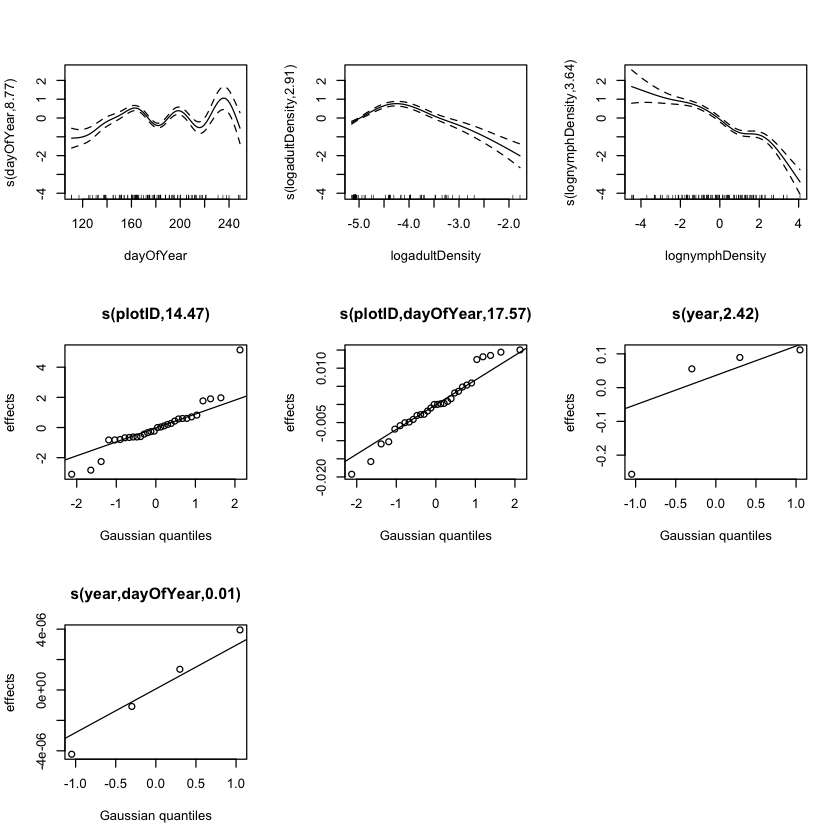


Method: REML   Optimizer: outer newton
full convergence after 12 iterations.
Gradient range [-0.001976844,6.502527e-05]
(score 830.9825 & scale 1).
Hessian positive definite, eigenvalue range [0.0003966431,9.721071].
Model rank =  105 / 105 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                          k'      edf k-index p-value
s(dayOfYear)         9.00000  8.76803    1.09    0.88
s(logadultDensity)   9.00000  2.91447    1.27    1.00
s(lognymphDensity)   9.00000  3.63524    0.96    0.33
s(plotID)           30.00000 14.46639      NA      NA
s(plotID,dayOfYear) 30.00000 17.57408      NA      NA
s(year)              4.00000  2.41593      NA      NA
s(year,dayOfYear)    4.00000  0.00939      NA      NA


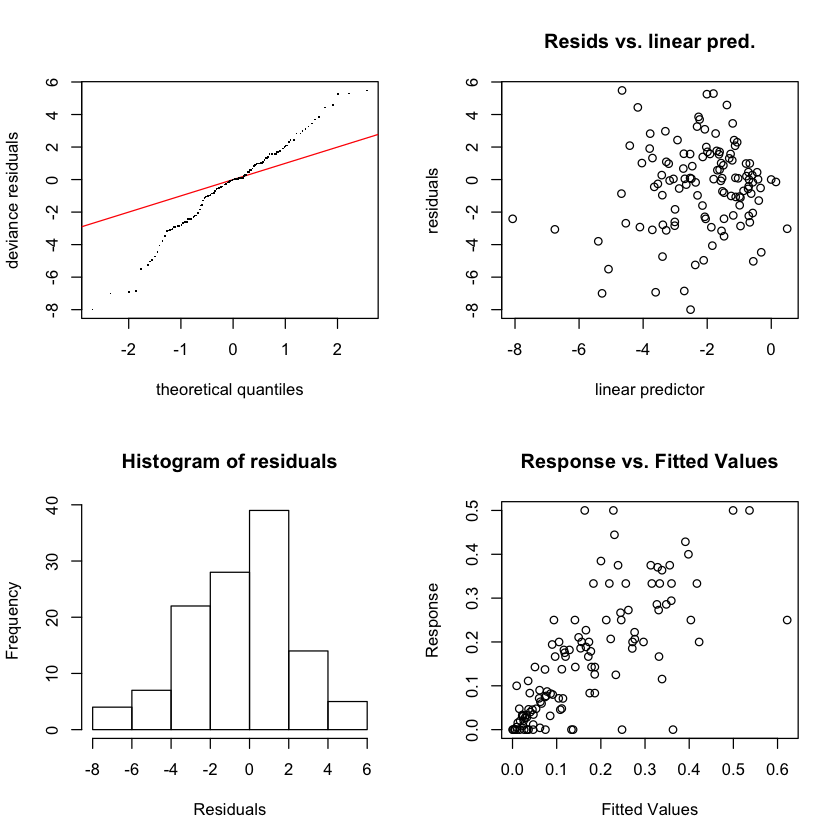

In [39]:
## Best AIC/Dev expl model
mod.gambin2_bestAIC <- gam(as.formula(frml_bin2_bestAIC)
                           , data=tck_borrelia_filtBin
                           , method="REML"
                           , family=binomial)
summary(mod.gambin2_bestAIC)
plot(mod.gambin2_bestAIC, pages=1)
gam.check(mod.gambin2_bestAIC)

In [40]:
## Best adjusted model to limit dayOfYear
mod.gambin2_bestAIC_adj <- gam(as.formula(frml_bin2_bestAIC_adjdayOfYear)
                       , data=tck_borrelia_filtBin
                       , method="REML"
                       , family=binomial)
summary(mod.gambin2_bestAIC_adj)
plot(mod.gambin2_bestAIC_adj, pages=1)
gam.check(mod.gambin2_bestAIC_adj)

ERROR: Error in as.formula(frml_bin2_bestAIC_adjdayOfYear): object 'frml_bin2_bestAIC_adjdayOfYear' not found


In [ ]:
### BEST MODEL:
mod.gambin_2 <- gam(as.formula(frml_bin2_bestDevexpl)
                    , data=tck_borrelia_filtBin
                    , method="REML"
                    , family=binomial)
summary(mod.gambin_2)
plot(mod.gambin_2, pages=1)
gam.check(mod.gambin_2)
vis.gam(mod.gambin_2, view = c("dayOfYear","logNLtckDensity"), theta=45)
vis.gam(mod.gambin_2, view = c("year","dayOfYear"), theta=45)


## BRMS Part I: binomial

In [ ]:
if (FALSE ) {
  brm_bin1 <- brm(bf(frml.bin1)
                 , seed=48
                 , data=tck_borrelia_adj
                 , family=bernoulli
                 # , prior = gambin_priors
                 , control=list(adapt_delta=0.99, max_treedepth=15)
                 )
  save(brm_bin1, file="brm_bin1.RData")
  # save(brm_bin_noelev, file="brm_bin_noelev.RData")
  
} else {
  load("brm_bin1.RData")
  # load("brm_bin_noelev.RData")
}
summary(brm_bin1)

In [ ]:
plot(brm_bin1)
conditional_effects(brm_bin1, effects = "dayOfYear")
conditional_effects(brm_bin1, effects = "lognymphDensity")


In [ ]:
# Look at how estimated probability maps to actual data for borrelia
fitted(brm_bin1) %>%
  cbind(brm_bin1$data) %>%
  ggplot() +geom_point(aes(x=Estimate, y=borrPresent))


In [ ]:
# Inspect error rate (false positive and false negative)
predict(brm_bin1) %>%
  cbind(brm_bin1$data) %>%
  mutate(Pred = ifelse(Estimate>0.5, 1, 0)) %>%
  select(borrPresent, Pred) %>% table()
12/(12+194) # false positive rate
29/(29+73) # false negative rate

In [ ]:
# See if there is correlation between probability and how many positives there actually were
fitted(brm_bin1) %>%
  cbind(tck_borrelia_adj[,c("proportionPositive","numberPositive", "numberTested")]) %>%
  ggplot() + geom_point(aes(x=numberPositive, y=Estimate, cex=numberTested)) 


In [ ]:
## Look at effect of various predictors
# Effect of day of year
fitted(brm_bin1) %>%
  cbind(brm_bin1$data) %>%
  left_join(tck_borrelia_adj) %>%
  ggplot() + geom_point(aes(x=dayOfYear, y=Estimate, col=nlcdClass)) + geom_point(aes(x=dayOfYear, y=borrPresent), col="red",alpha=0.2) + geom_smooth(aes(x=dayOfYear, y=borrPresent))
conditional_smooths(brm_bin1, smooths="s(dayOfYear)")


In [ ]:
# Effect of tck density
fitted(brm_bin1) %>%
  cbind(brm_bin1$data) %>%
  left_join(tck_borrelia_adj) %>%
  ggplot() + geom_point(aes(x=lognymphDensity, y=Estimate, col=domainID)) + geom_point(aes(x=lognymphDensity, y=borrPresent), col="red",alpha=0.2) + geom_smooth(aes(x=lognymphDensity, y=borrPresent)) 
conditional_smooths(brm_bin1, smooths="s(lognymphDensity)")


In [ ]:
# Since each sample is IID, we can include all positive results in poisson component of model, and use fitted probabilities to determine
# whether each zero is a "binomial" zero or a "poisson" zero.
tck_borrelia_filtbin_brm <- tck_borrelia_adj %>%
  cbind(predict(brm_bin1)) %>%
  filter(borrPresent>0 | Estimate>0.5)

In [ ]:
## Now try to fit a second distribution?
tck_borrelia_filtbin_brm %>%
  ggplot() + geom_histogram(aes(x=proportionPositive), bins=20)
tck_borrelia_filtbin_brm %>%
  ggplot() + geom_histogram(aes(x=numberPositive), bins=20)


## BRMS: Part II

In [ ]:
# Re-format frml for brm
frml_bin2_adj  <- gsub(pattern="cbind(numberPositive,numberTested)",replacement="numberPositive | trials(numberTested)",frml_bin2_bestDevexpl, fixed = TRUE)


In [ ]:
if (FALSE) {
  brm_bin2 <- brm(bf(as.formula(frml_bin2_adj))
                  , data=tck_borrelia_filtbin_brm
                  , family=binomial()
                  , seed=24
                  , control = list(adapt_delta=0.95, max_treedepth=15)
  )
  save(brm_bin2, file = "brm_bin2.RData")
} else {
  load("brm_bin2.RData")
}

summary(brm_bin2)

In [ ]:
plot(brm_bin2)
conditional_smooths(brm_bin2, smooths = "s(dayOfYear)")
conditional_smooths(brm_bin2, smooths = "s(lognymphDensity, sp = 1)")
conditional_smooths(brm_bin2, smooths = "s(logadultDensity, sp = 1)")

In [ ]:
conditional_effects(brm_bin2, effects = "dayOfYear")
conditional_effects(brm_bin2, effects = "logadultDensity")
conditional_effects(brm_bin2, effects = "lognymphDensity")


In [ ]:
predict(brm_bin2) %>%
  cbind(tck_borrelia_filtbin_brm[,c("numberPositive","dayOfYear","numberTested","logNLtckDensity","year","plotID")]) %>%
  ggplot() + geom_point(aes(x=log(numberPositive+1), y=log(Estimate+1))) +
  geom_segment(aes(x=log(numberPositive+1), xend=log(numberPositive+1), y=log(Q2.5+1), yend=log(Q97.5+1)), col="red")

